# Import Dependencies

In [1]:
# Data Manipulation Libraries: Standard dataframes and array libraries
import pandas as pd
import numpy as np
# from datetime import datetime
from datetime import datetime, timedelta

# Data Visualization Libraries:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Data analysis
from scipy import stats
from scipy.stats import skew 

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Displaying plots in jupter notebook
%matplotlib inline
# Displaying pandas columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Import data

In [2]:
# import data using read_csv() method for 
# Phase 1: Baseline KPI analysis
customers = pd.read_csv("static/data/customers.csv")
purchases = pd.read_csv("static/data/in_app_purchases.csv")

# Phase 2: A/B testing phase
revenue = pd.read_csv("static/data/revenue.csv")
paywall_demo = pd.read_csv("static/data/user_demographics_paywall.csv")

# Phase 3: A/B testing analyis
ab_results = pd.read_csv("static/data/ab_testing_results.csv")

# Data wranging
 - customer and purchases csv files

### Change datatypes

In [3]:
# Rename column date in the customers df
customers.columns = ['date' if x=='reg_date' else x for x in customers.columns]

In [4]:
# Convert price to currency format (without the $ sign as this would change it to a string object)
purchases['price'] = purchases['price'].apply(lambda x: '{:.2f}'.format((x/100)))
purchases['price'] = purchases['price'].astype('float')

In [5]:
sku_dict = {'sku_eight_2099': 'sku_$0.99',
            'sku_five_899':'sku_$8.99',
            'sku_four_599':'sku_$5.99',
            'sku_one_199' :'sku_$1.99',
            'sku_seven_1499':'sku_$4.99',
            'sku_six_1299':'sku_$2.99', 
            'sku_three_499':'sku_$4.99',
            'sku_two_299':'sku_$2.99'}
# Rename values in the column
purchases['sku'].replace(sku_dict, inplace= True)

In [6]:
# Change date columns from objects to datetime
purchases['date'] = purchases['date'].astype('datetime64[ns]')
customers["date"] = customers["date"].astype('datetime64[ns]')
# Convert uid into an int
customers['uid'] = customers['uid'].astype(int)

In [7]:
# Rename values in the device feature of customers
customers['device'].replace({'and':'android'}, inplace= True)

# Update country names in the customers df
customers['country'].replace({'BRA':'Brazil', 'CAN':'Canada', 'DEU': 'Germany', 'FRA':'France', 'TUR':'Turkey'}, inplace= True)

In [8]:
# Change columns where unique values < 10 to category
purchases["sku"] = purchases["sku"].astype('category')
# Use a .apply() to change multiple columns in the customers df
customer_cols = ['device', 'gender', 'country']
customers[customer_cols] = customers[customer_cols].apply(lambda x: x.astype('category'))

### First Subset: <font color="red">customer_purchases</font> purchases and customers merged using .merge()

In [9]:
# Merge on the 'uid'
customer_purchases = purchases.merge(customers, on=['uid'], how='inner')

In [10]:
# Update column names for clarity
customer_purchases.columns = ['purchase_date' if x=='date_x' else x for x in customer_purchases.columns]
customer_purchases.columns = ['registration_date' if x=='date_y' else x for x in customer_purchases.columns]

In [11]:
# Add a lapse date column: the date that their 7-day free trial ended
customer_purchases["week1_lapse_date"] = customer_purchases['registration_date'] + timedelta(days=7)
customer_purchases["week2_lapse_date"] = customer_purchases['registration_date'] + timedelta(days=14)

In [12]:
# Assign binary numbers to columns if user made a purchase during that period
customer_purchases["purchase_dur_week1"] = np.where(customer_purchases['purchase_date'] <= customer_purchases["week1_lapse_date"], 1, 0)
customer_purchases["purchase_dur_week2"] = np.where(customer_purchases['purchase_date'] <= customer_purchases["week2_lapse_date"], 1, 0)

In [13]:
# Rearrange columns
customer_purchases = customer_purchases[['uid','registration_date', 'week1_lapse_date', 'week2_lapse_date',
       'purchase_dur_week1', 'purchase_dur_week2', 'gender', 'age','device', 'country', 'purchase_date', 'sku', 'price']]

In [14]:
print(f'The number of observations in the dataset is: {len(customer_purchases)}')

The number of observations in the dataset is: 9006


## User Demographics

### Univariate Dataframe <font color="red">unique_users</font> Removed duplicate 'uid'
- Country: Users by country
- Age: Users by age
- Gender: Gender demographics
- Device: Device types used

In [15]:
# Create df and drop duplicate rows, only interested in unique users
unique_users = customer_purchases.drop_duplicates(subset='uid', keep='first')

In [16]:
# Number of unique users
unique_users['country'].shape

(1322,)

In [17]:
# Number of unique users by country
unique_users['country'].value_counts()

USA        539
Brazil     385
Turkey     129
Germany    126
France      88
Canada      55
Name: country, dtype: int64

In [18]:
# Age descriptive statistics
unique_users['age'].describe().to_frame()

,age
count,1322.000000
mean,24.072617
std,9.555172
min,15.000000
25%,17.000000
50%,21.000000
75%,28.000000
max,75.000000


In [19]:
# Age descriptive statistics
format_dict = {'Percent': '{0:.2%}'}
gender_demo = unique_users['gender'].value_counts().to_frame()
gender_demo["Percent"] = (gender_demo['gender']/unique_users['gender'].count())
gender_demo.style.format(format_dict)

,gender,Percent
F,712,53.86%
M,610,46.14%


In [20]:
# Determine the skeness of the age distribution
print( '\nSkewness for data : ', skew(unique_users['age'])) 


Skewness for data :  1.6899616122843457


In [21]:
# Age descriptive statistics
format_dict = {'Percent': '{0:.2%}'}
device_demo = unique_users['device'].value_counts().to_frame()
device_demo["Percent"] = device_demo['device']/unique_users['device'].count()
device_demo.style.format(format_dict)

,device,Percent
android,790,59.76%
iOS,532,40.24%


### Figure 1. User demographics

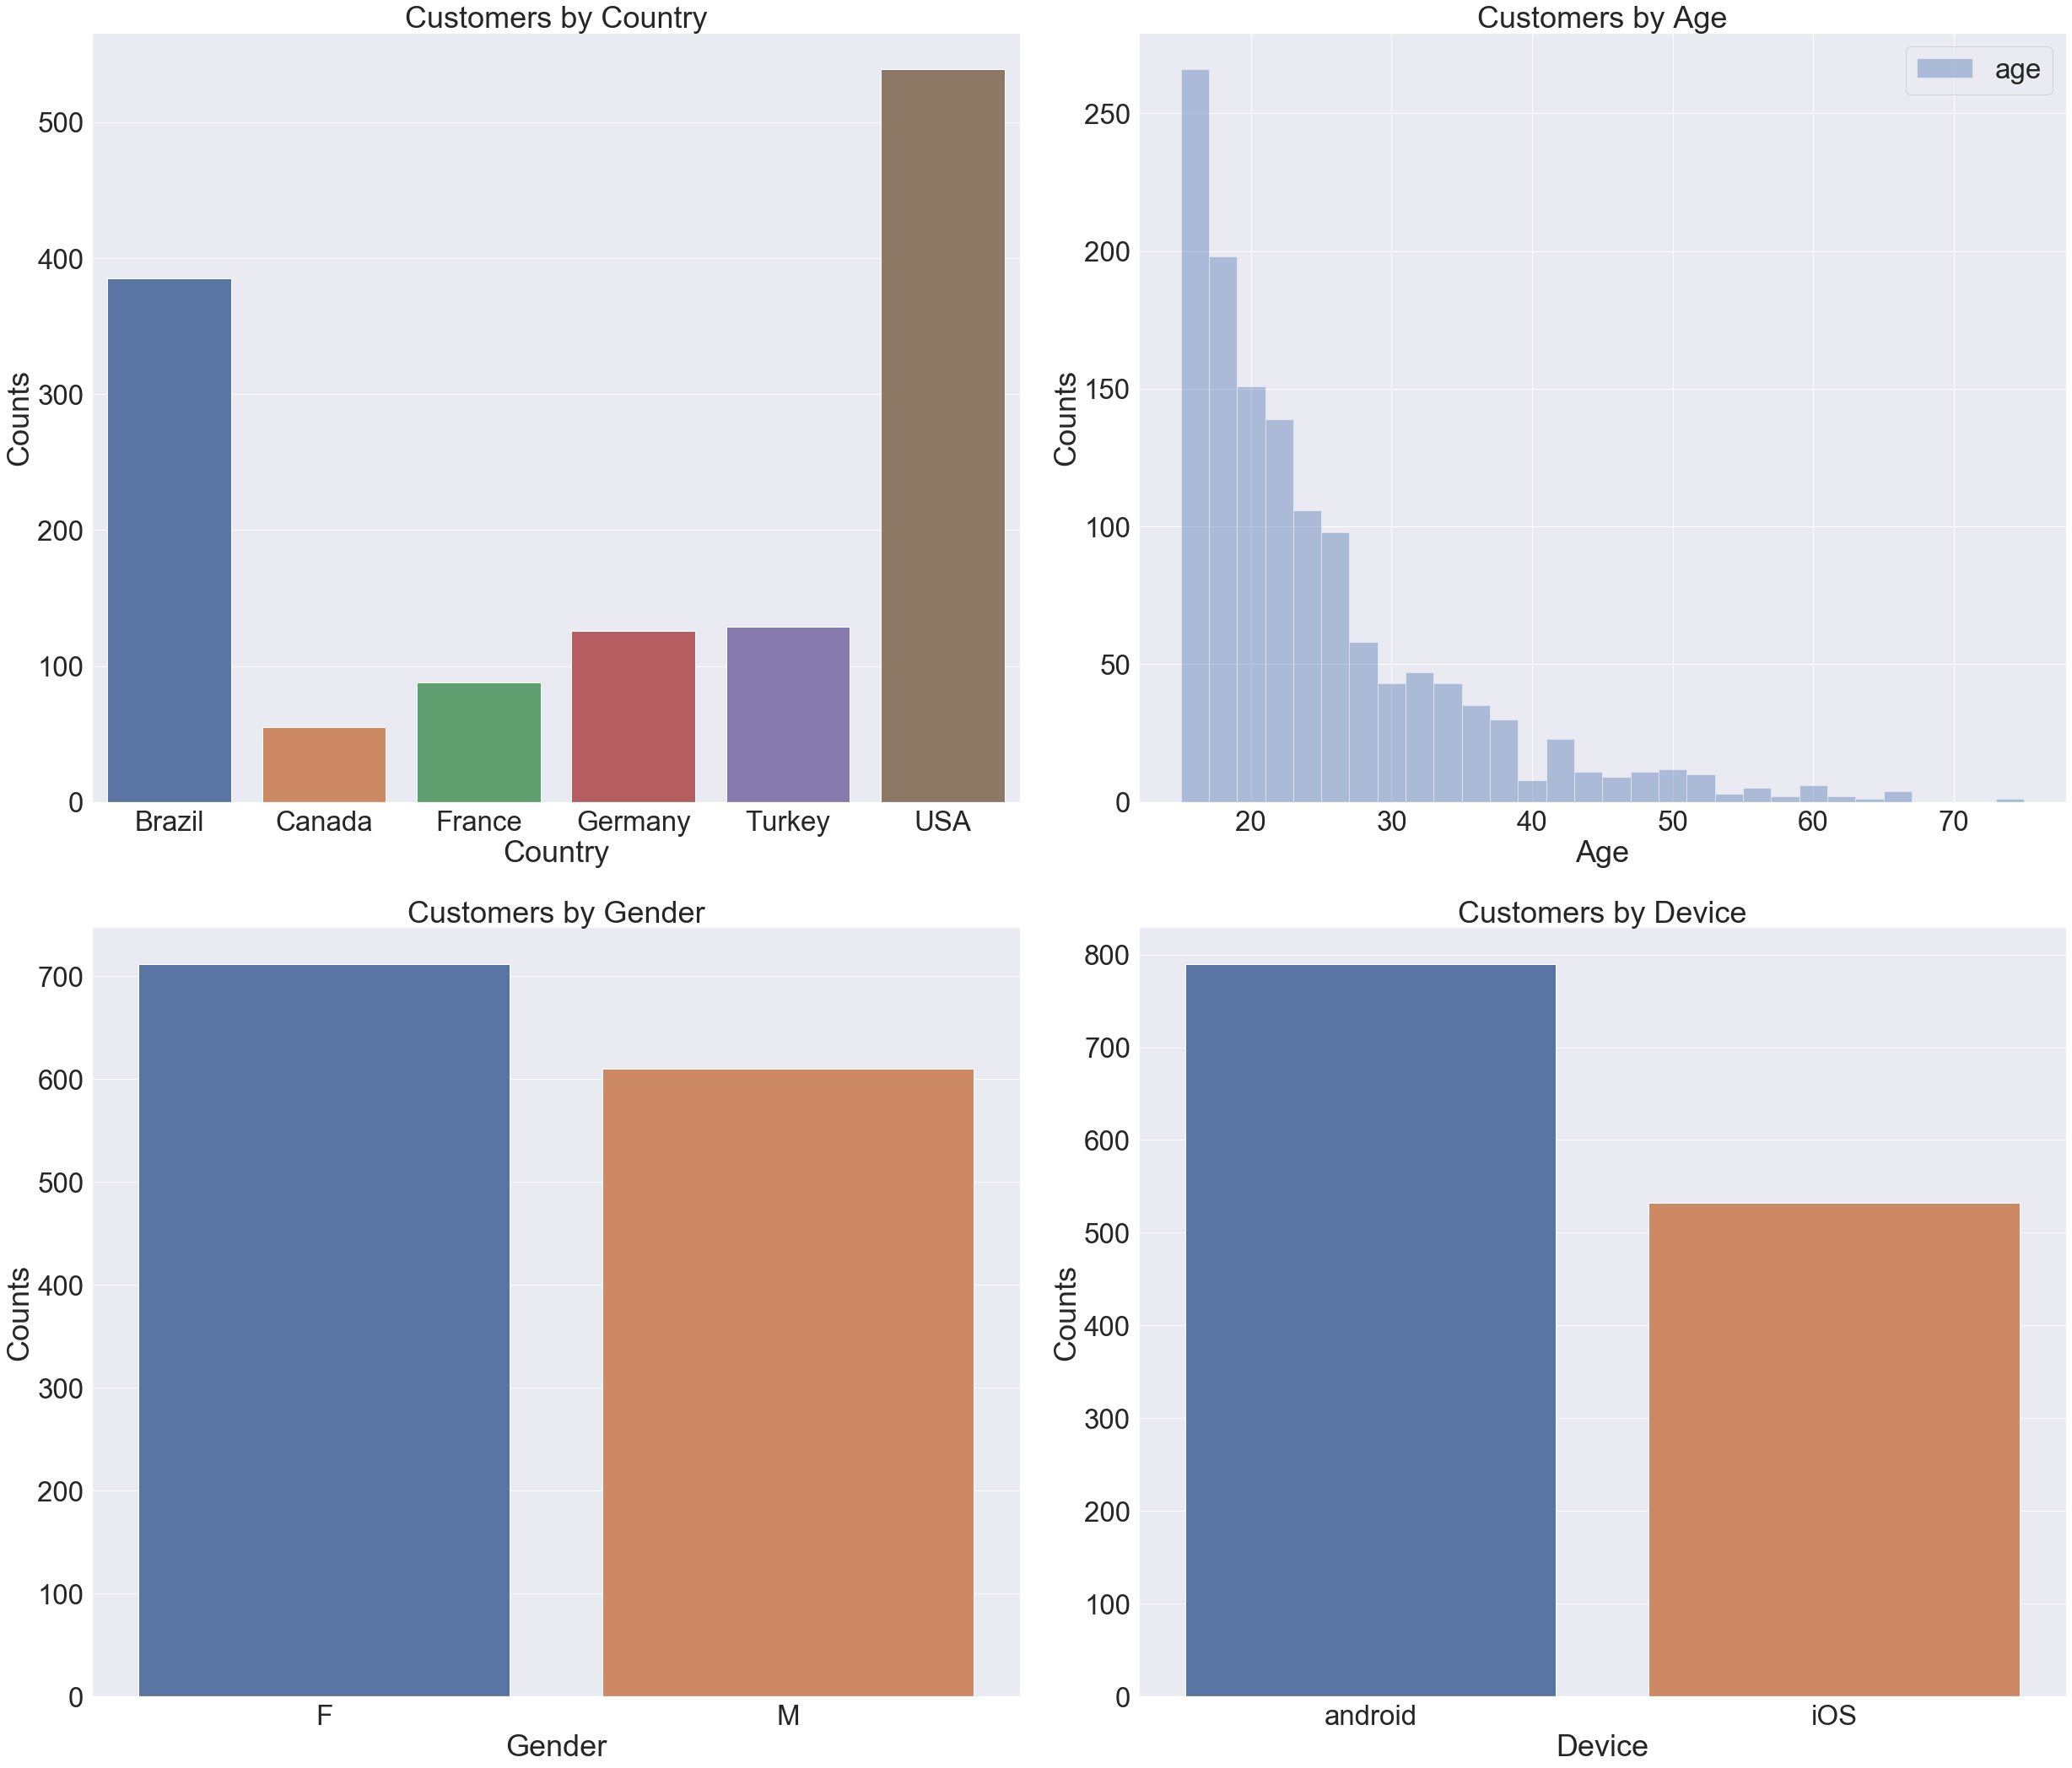

In [23]:
# List of features
customer_demo_list = ['country' , 'age', 'gender', 'device']
# Test function
fig = plt.figure(figsize=(35,30))
# plt.rcParams.update({'font.size': 28})
fig.subplots_adjust(hspace=1, wspace=0.2)
for demo, num in zip(customer_demo_list, range(1,5)):
    if demo == 'age':
        ax = fig.add_subplot(2,2, num)
        sns.distplot(unique_users[demo], kde=False, ax=ax, label=demo)
        sns.set(font_scale=3)
        ax.legend()
        ax.set_ylabel('Counts')
        ax.set_xlabel(demo.capitalize())
        ax.set_title(f'Customers by {demo.capitalize()}')
    else:
        ax = fig.add_subplot(2,2, num)
        sns.countplot(x=demo, data=unique_users, ax=ax)
        sns.set(font_scale=3)
        ax.set_ylabel('Counts')
        ax.set_xlabel(demo.capitalize())
        ax.set_title(f'Customers by {demo.capitalize()}')
    
plt.tight_layout()
plt.savefig("static/images/figure1_user_demographics.png", bbox_inches='tight')
plt.show()

## User Demographics

### Multivariate
- Age distribution by country
- Age distribution by gender
- Age distribution by device
- Gender distribution by country
- Gender distribution by device
- Device distribution by country

### Statistical tests to determine if the mean ages of male and female users or between android and iOSC users differ significantly

In [39]:
# Items to be iterated over for 
category_list = ["gender", "device"]
genders = np.array(unique_users["gender"].astype('str').unique())
devices = np.array(unique_users["device"].astype('str').unique())
items = [genders, devices]
test_results = []

In [40]:
# Function for Mann Whitney
def cal_mannwhitney(categories, item):
    for cat in categories:
        for item in items:
            x = unique_users[unique_users[cat] == item[0]]["age"].values
            y = unique_users[unique_users[cat] == item[1]]["age"].values
            ustat, pval = stats.mannwhitneyu(x, y)
            if ustat != 0.00 and pval != 0.00:                  
                test_results.append((round(ustat,4), round(pval, 4)))
            else:
                next
    return test_results

In [41]:
# Cal mann whitney for gender ages
mw_test = cal_mannwhitney(category_list, items)

In [43]:
# Create a dataframe for results
mw_df = pd.DataFrame(mw_test, columns =['U-Statistic', 'p-Value']) 

In [45]:
# Rename index (rows)
mw_df = mw_df.rename(index={0: 'Gender', 1:'Device'})
mw_df

,U-Statistic,p-Value
Gender,208816.0,0.1135
Device,199885.5,0.0656


### Statistical tests to determine if the mean ages of users in different countries differ significantly

In [93]:
brazil = unique_users.loc[unique_users["country"] == 'Brazil']['age'].values
turkey = unique_users.loc[unique_users["country"] == 'Turkey']['age'].values
usa = unique_users.loc[unique_users["country"] == 'USA']['age'].values
canada = unique_users.loc[unique_users["country"] == 'Canada']['age'].values
germany = unique_users.loc[unique_users["country"] == 'Germany']['age'].values
france = unique_users.loc[unique_users["country"] == 'France']['age'].values

In [96]:
stats.kruskal(brazil, turkey, usa, canada, germany, france)

KruskalResult(statistic=5.020259166787596, pvalue=0.4134127397946722)

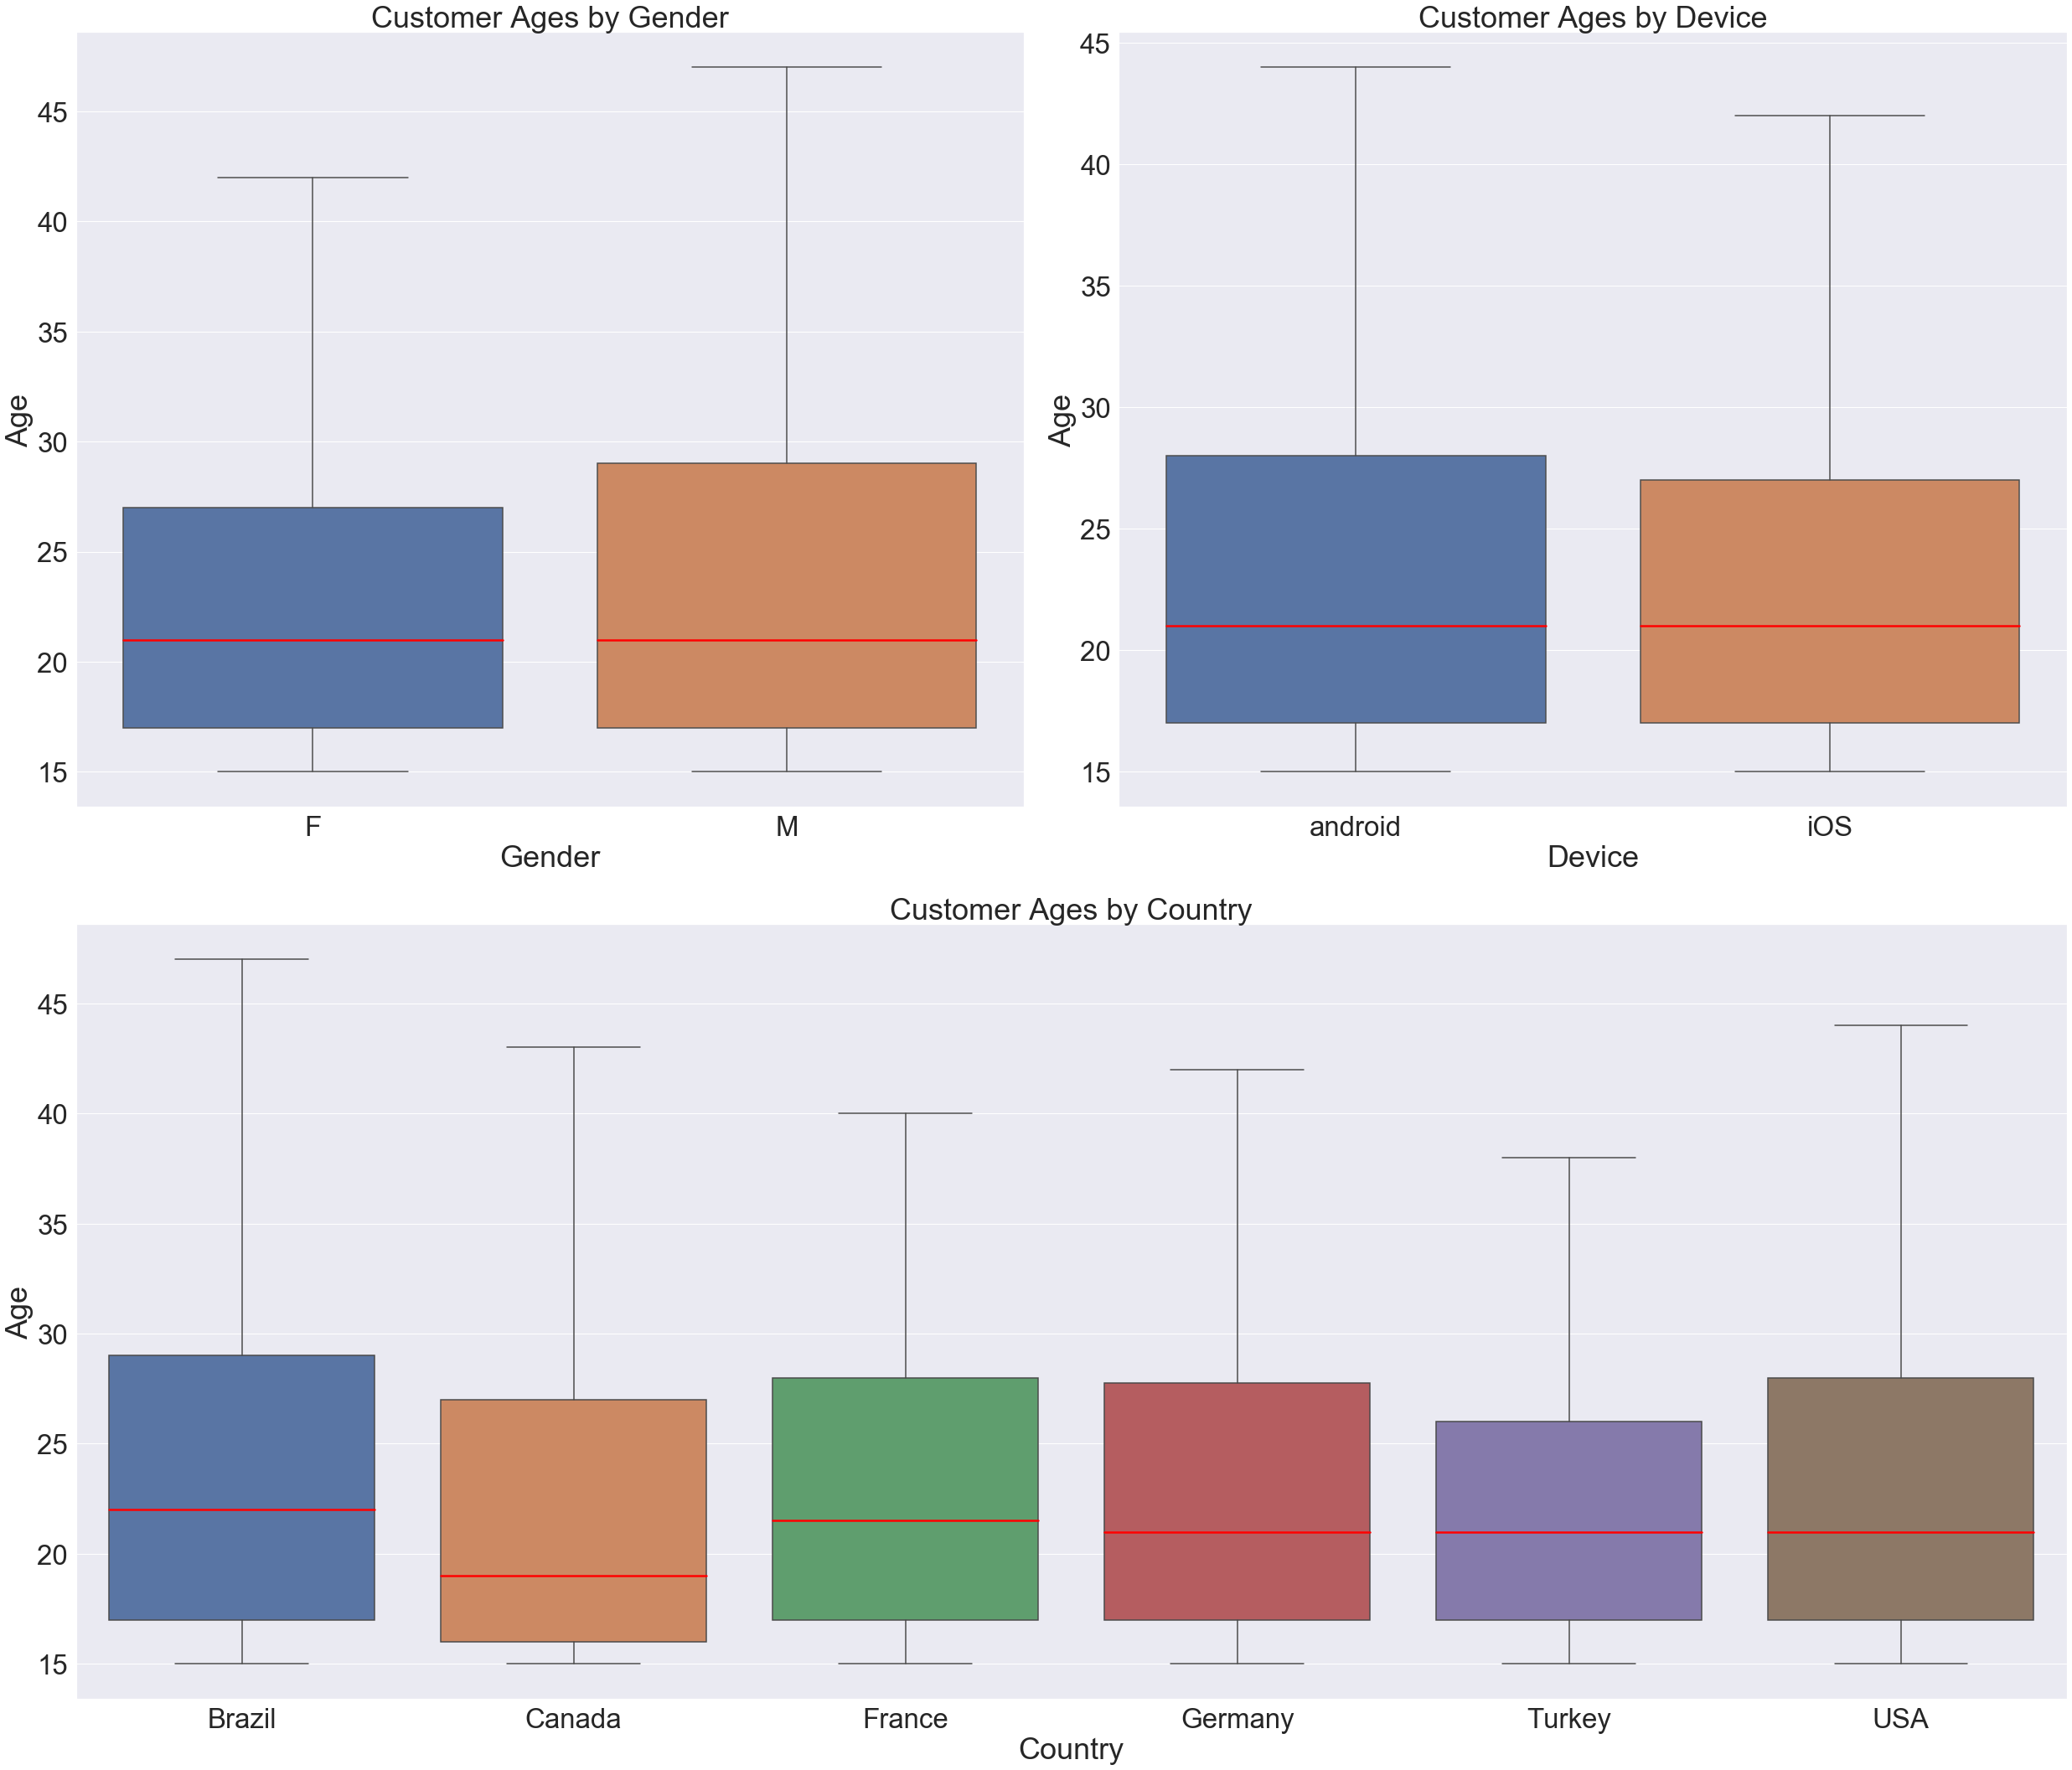

In [68]:
customer_demo_list = ['gender', 'device', 'country']
fig = plt.figure(figsize=(35,30))
plt.rcParams.update({'font.size': 28})
fig.subplots_adjust(hspace=1, wspace=0.2)
for demo, num in zip(customer_demo_list, range(1,4)):
    if num == 3:
        ax = fig.add_subplot(212)
        sns.boxplot(x=demo, y="age", data=unique_users, medianprops={'color':'red', 'linewidth': 2.5}, sym='', ax=ax)
        ax.set_ylabel('Age')
        ax.set_xlabel(demo.capitalize())
        ax.set_title(f"Customer Ages by {demo.capitalize()}")
    else:
        ax = fig.add_subplot(2,2, num)
        sns.boxplot(x=demo, y="age", data=unique_users, medianprops={'color':'red', 'linewidth': 2.5}, sym='', ax=ax)    
        ax.set_ylabel('Age')
        ax.set_xlabel(demo.capitalize())
        ax.set_title(f"Customer Ages by {demo.capitalize()}")
    
plt.tight_layout()
plt.savefig("static/images/figure2_user_demographics.png", bbox_inches='tight')
plt.show()

Customers in France have the highest median age, while Germany has the youngest customers.
Most customers appear to be under 30 years of age.

- Gender distribution by country
- Gender distribution by device
- Device distribution by country

Men are generally older than females in all countried but brazil.

In [144]:
demo_pivot = pd.pivot_table(unique_users, index=['country'], columns=['gender'], values=['age'], aggfunc=np.mean)
demo_pivot

age           
gender           F          M
country                      
Brazil   23.720812  24.457447
Canada   21.266667  24.400000
France   21.936170  26.390244
Germany  23.962025  23.234043
Turkey   23.400000  24.203704
USA      24.105634  24.701961

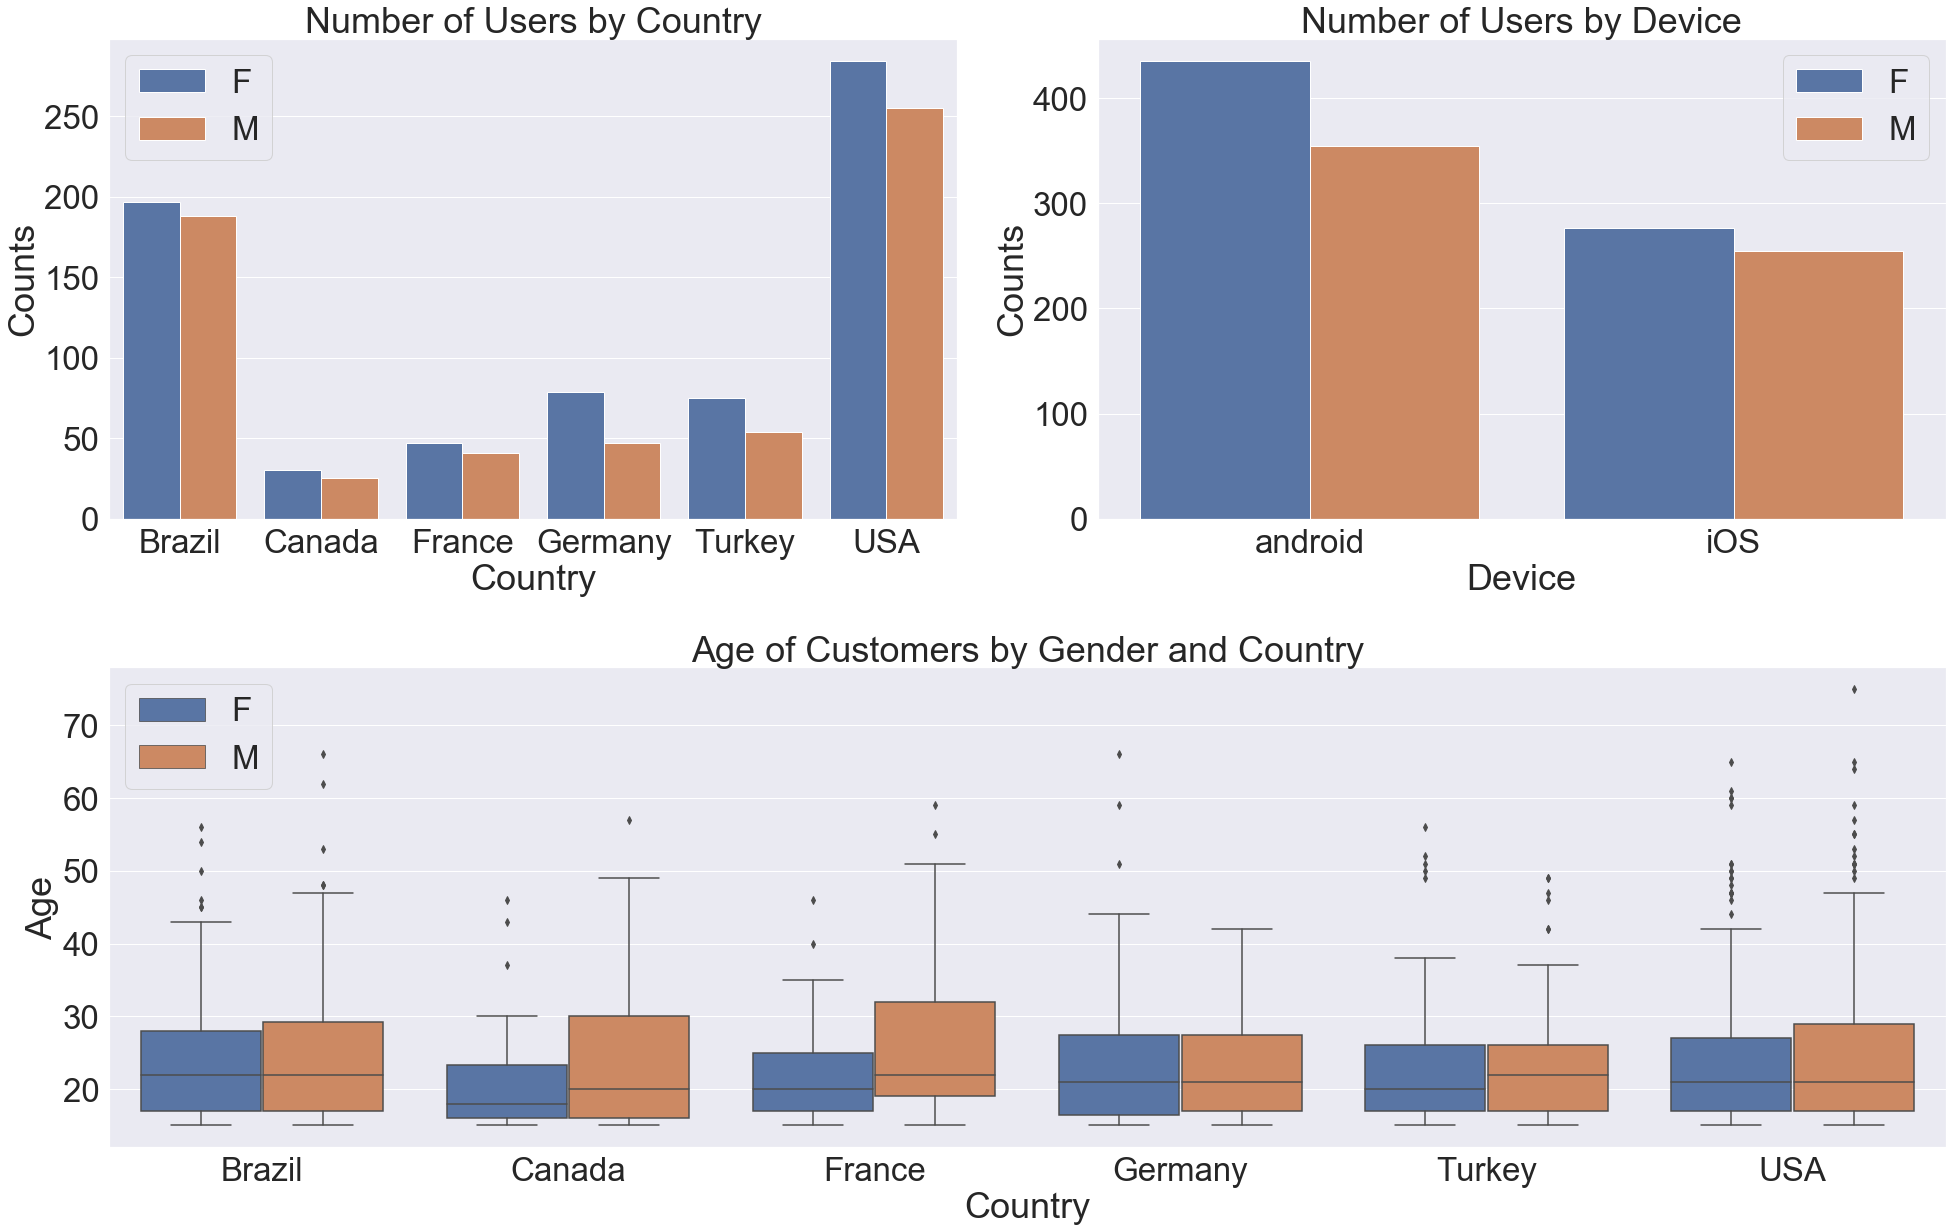

In [100]:
customer_demo_list = ['country', 'device', 'age']
fig = plt.figure(figsize=(28,18))
# plt.rcParams.update({'font.size': 8})
fig.subplots_adjust(hspace=1, wspace=0.2)
for demo, num in zip(customer_demo_list, range(1,4)):
    if num == 3:    
        ax = fig.add_subplot(212)
        sns.boxplot(x="country", y="age", hue="gender", data=unique_users, ax=ax)
        ax.set_ylabel('Age')
        ax.set_xlabel('Country')
        ax.set_title("Age of Customers by Gender and Country")
        ax.legend()  
    else:
        ax = fig.add_subplot(2,2, num)
        sns.countplot(x=demo, hue='gender', data=unique_users, ax=ax)    
        ax.set_ylabel('Counts')
        ax.set_xlabel(demo.capitalize())
        ax.set_title(f"Number of Users by {demo.capitalize()}")
        ax.legend(loc='best')
    
plt.tight_layout()
plt.savefig("static/images/figure3_user_demographics.png", bbox_inches='tight')
plt.show()

There are more female customers than male customers.

### Devices used by country

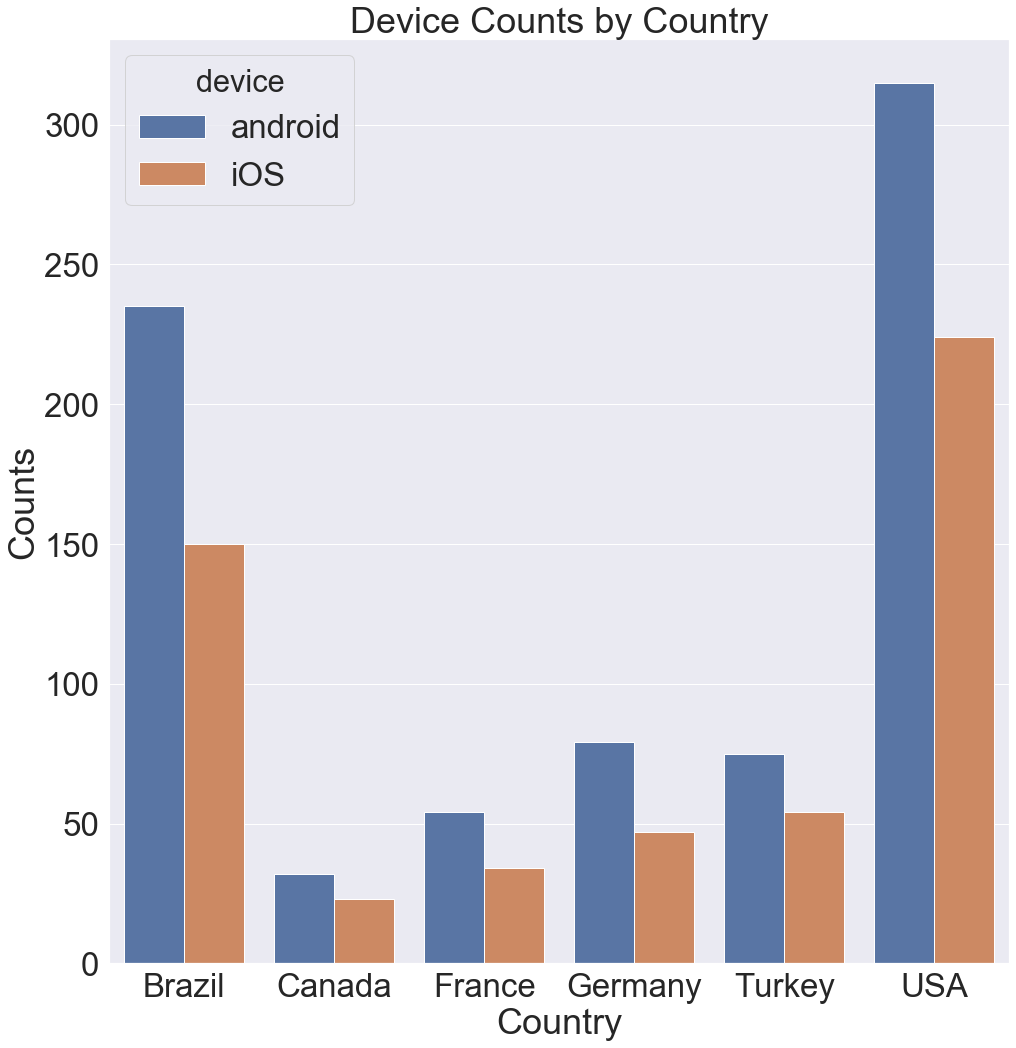

In [146]:
fig = plt.figure(figsize=(15,15))
ax = sns.countplot(x="country", hue="device", data=unique_users)
plt.tight_layout()
plt.ylabel("Counts")
plt.xlabel("Country")
plt.title("Device Counts by Country")
plt.savefig("static/images/figure4_user_demographics.png", bbox_inches='tight')
plt.show()

Android is the dominant device type for all countries.

## Baseline Sales EDA Key performance index (KPI)
- Sales by Country : What is the median price spent
- Average Sales by Country: (how many purchases do people make)
- Sales by Age: What is the median age of customers
- Average Sales by Age: (how many purchases do people make) (dot plot)
- Sales by Gender: What genders are a larger proportion of sales
- Average Sales by Gender: How many purchases do men and women make
- Sales by Device:
- Average Sales by device:

### SKU Sales by Demographic
- Sku by country: which products are popular
- Sku by age:
- Sku by gender
- Sku by device:


### Multivariate Sales Analysis
 - Sales by country and gender (cat)
 - Sales by country and device (cat)
 - Sales by country and age (cont)
 
### Multivariate Sales Analysis
 - Sales by country, gender, age (cat)
 - Sales by country, gender, device (cat)
 - Sales by country, age, device (cont)

## Baseline Sales EDA Key performance index (KPI)
- Sales by Country : What is the median price spent
- Average Sales by Country: (how many purchases do people make)
- Sales by Age: What is the median age of customers
- Average Sales by Age: (how many purchases do people make) (dot plot)
- Sales by Gender: What genders are a larger proportion of sales
- Average Sales by Gender: How many purchases do men and women make
- Sales by Device:
- Average Sales by device:

<font color="red">customer_purchases</font>

In [186]:
# Get the number of unique users by country
users_by_country = unique_users.groupby('country')['uid'].agg('count').to_frame()
users_by_country.reset_index(inplace=True)
users_by_country

,country,uid
0,Brazil,385
1,Canada,55
2,France,88
3,Germany,126
4,Turkey,129
5,USA,539


In [215]:
# Group data by country and aggregate by price
purchase_by_country = customer_purchases.groupby('country').agg({'price':{'count', 'sum', 'mean', 'std', 'median'}})
# Drop the price multilevel label
purchase_by_country.columns = purchase_by_country.columns.droplevel(0)
# Reshape index with countries in rows to a column
purchase_by_country.reset_index(inplace=True)
# Rearragnge columns
purchase_by_country = purchase_by_country[['country', 'count', 'sum', 'std', 'mean','median']]
# Hide index when displaying column
purchase_by_country.style.hide_index()

country,count,sum,std,mean,median
Brazil,2694,11041.1,1.91505,4.09839,4.99
Canada,399,1589.01,1.85869,3.98248,2.99
France,544,2185.56,1.86397,4.01757,2.99
Germany,915,3742.85,1.7821,4.09055,4.99
Turkey,804,3339.96,1.93877,4.15418,4.99
USA,3650,14735.5,1.86734,4.03712,2.99


In [216]:
# Merge purcahse_by_country with users_by_country
purchases_by_country_merged = purchase_by_country.merge(users_by_country, on=['country'], how='inner')
purchases_by_country_merged

,country,count,sum,std,mean,median,uid
0,Brazil,2694,11041.06,1.915050,4.098389,4.99,385
1,Canada,399,1589.01,1.858687,3.982481,2.99,55
2,France,544,2185.56,1.863968,4.017574,2.99,88
3,Germany,915,3742.85,1.782098,4.090546,4.99,126
4,Turkey,804,3339.96,1.938766,4.154179,4.99,129
5,USA,3650,14735.50,1.867339,4.037123,2.99,539


In [218]:
purchases_by_country_merged.rename(columns={'uid':'total users', 'count':'total # purchases', 'sum':'total paid', 'mean': 'mean purchase price', 'std': 'std purchase price', 'median' : 'median purchase price'}, inplace=True)
# Add feature column (average number of purchses by)
purchases_by_country_merged["average nbr purchases"] = purchases_by_country_merged["total # purchases"]/purchases_by_country_merged['total users']
# Reorder columns
purchases_by_country_merged = purchases_by_country_merged[['country', 'total users', 'total # purchases', 'average nbr purchases', 'total paid', 'mean purchase price', 'std purchase price', 'median purchase price']]
purchases_by_country_merged

,country,total users,total # purchases,average nbr purchases,total paid,mean purchase price,std purchase price,median purchase price
0,Brazil,385,2694,6.997403,11041.06,4.098389,1.915050,4.99
1,Canada,55,399,7.254545,1589.01,3.982481,1.858687,2.99
2,France,88,544,6.181818,2185.56,4.017574,1.863968,2.99
3,Germany,126,915,7.261905,3742.85,4.090546,1.782098,4.99
4,Turkey,129,804,6.232558,3339.96,4.154179,1.938766,4.99
5,USA,539,3650,6.771800,14735.50,4.037123,1.867339,2.99


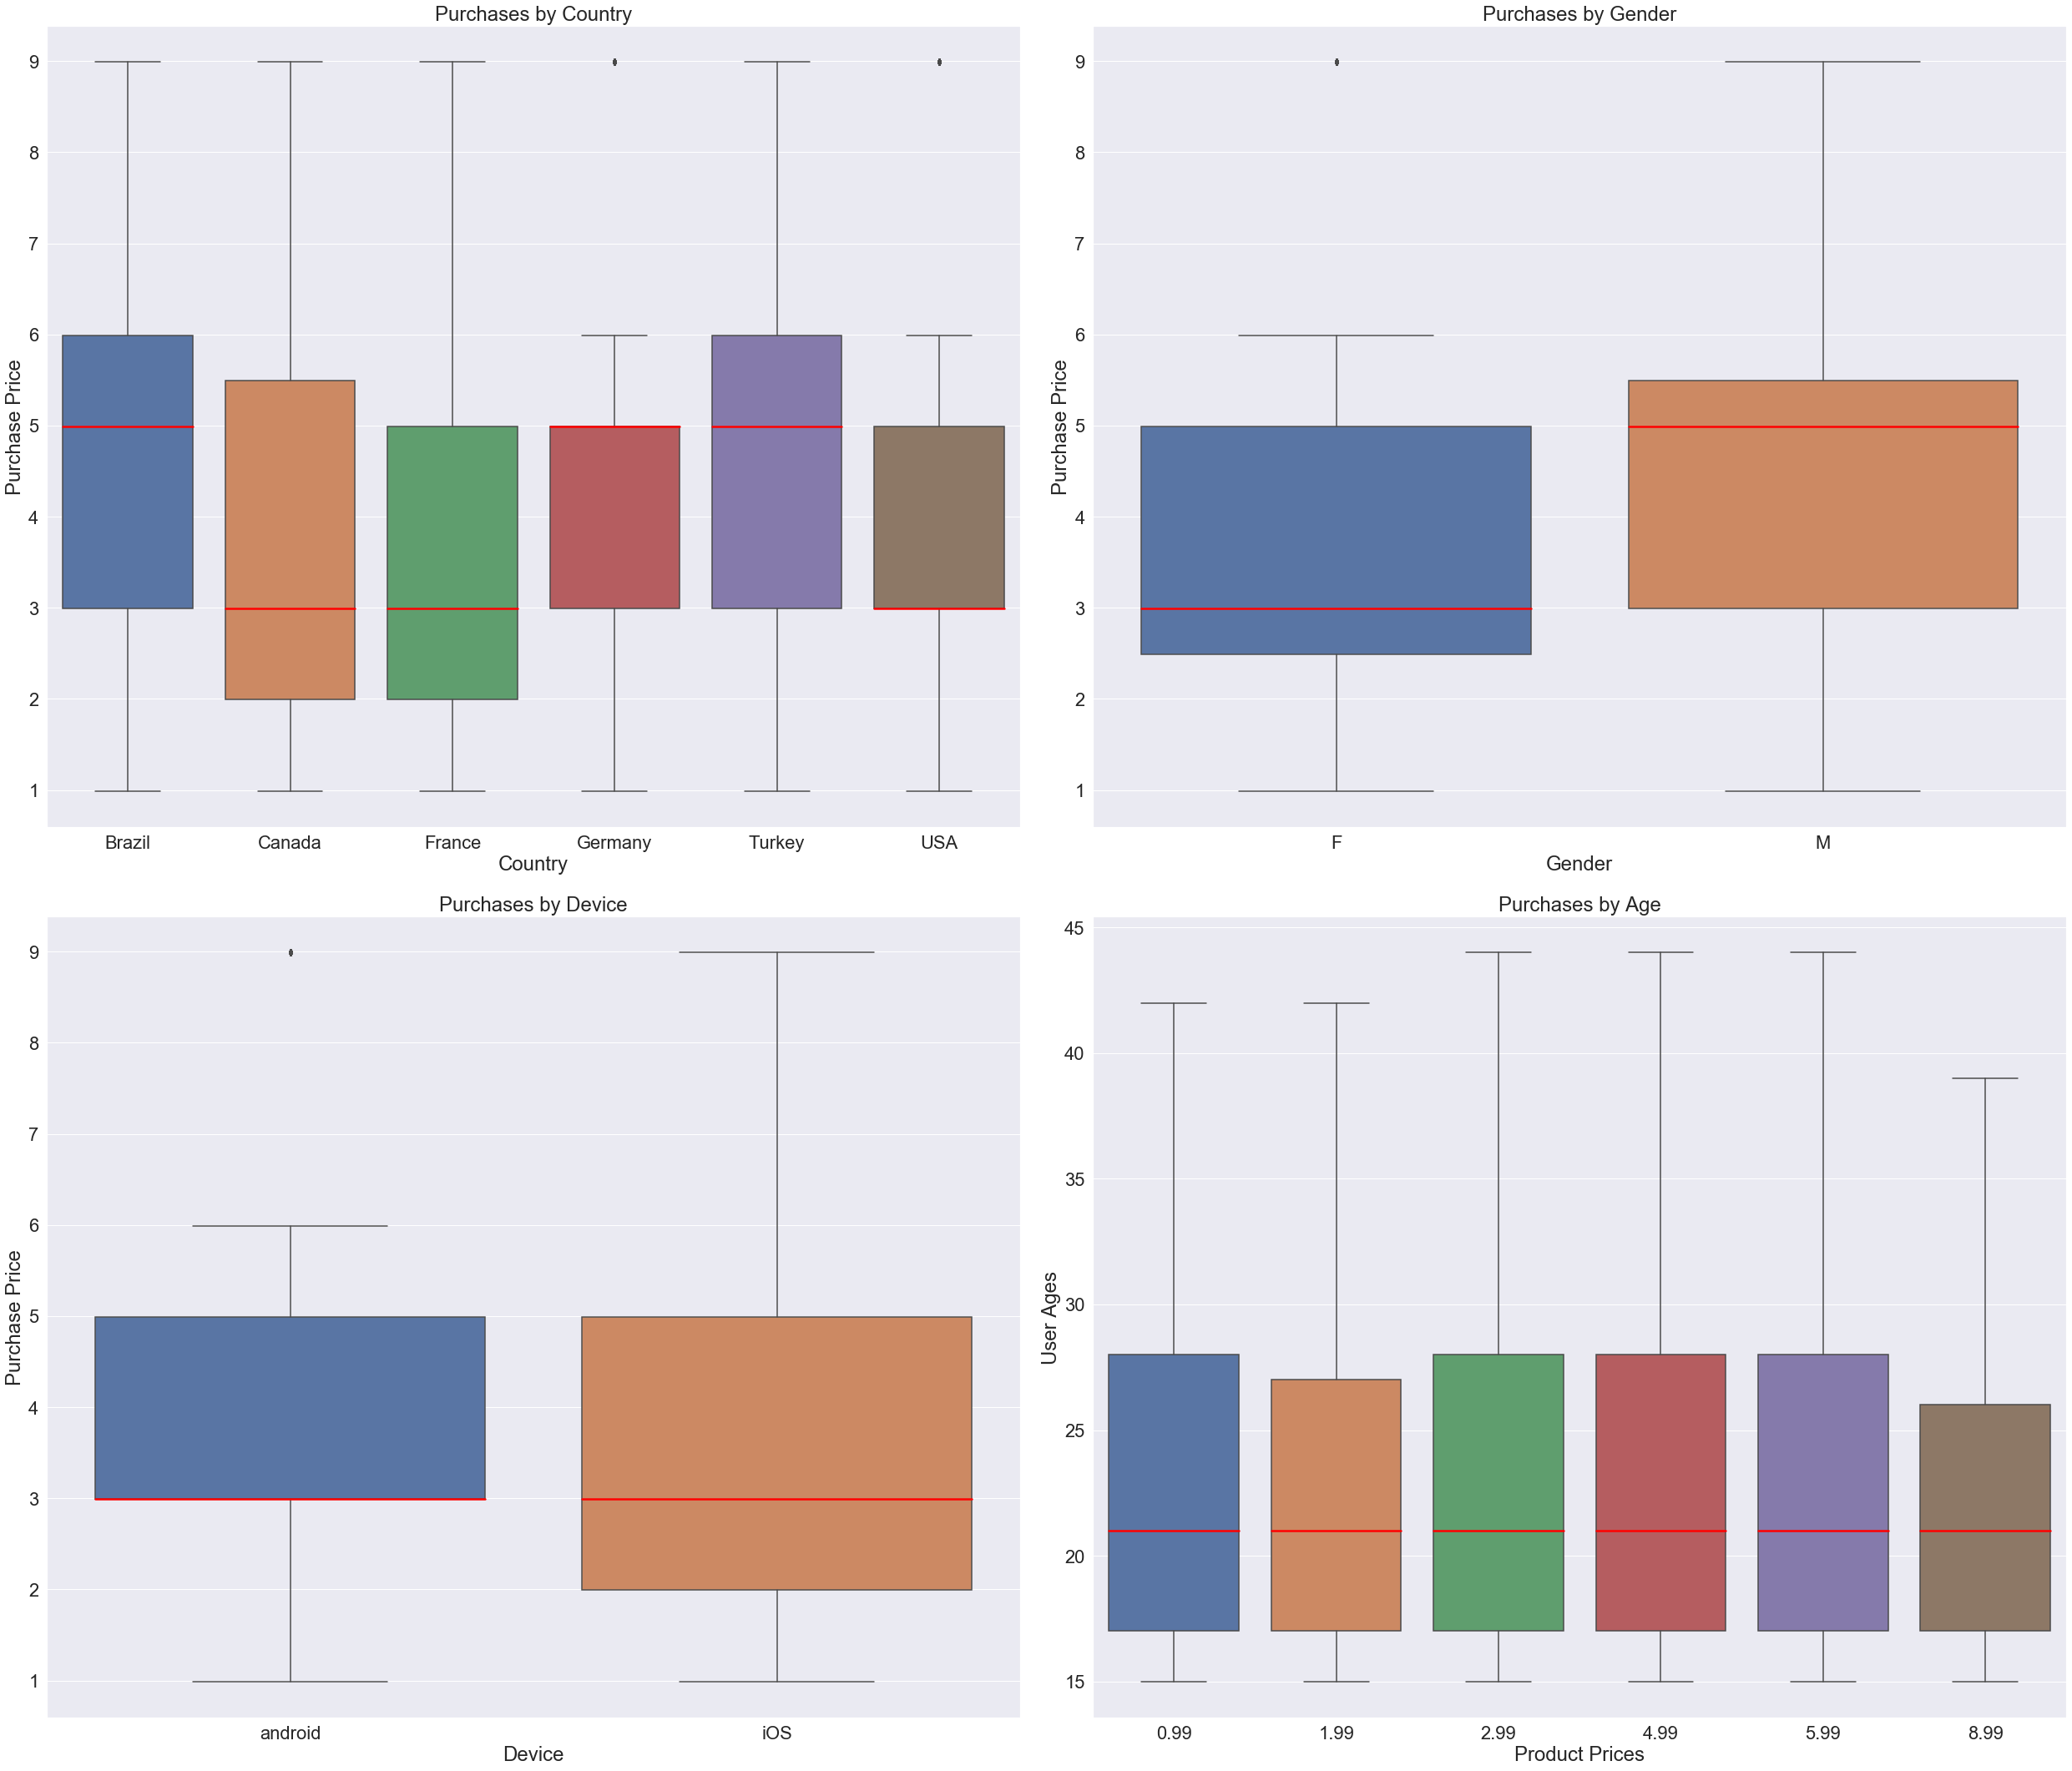

In [151]:
sales_demo = ['country', 'gender', 'device', 'age']
fig = plt.figure(figsize=(35,30))
fig.subplots_adjust(hspace=1, wspace=0.2)
for demo, num in zip(sales_demo, range(1,5)):
    if demo == 'age':
        ax = fig.add_subplot(2,2, num)
        sns.boxplot(x=customer_purchases['price'], medianprops={'color':'red', 'linewidth': 2.5}, y=customer_purchases['age'], sym="", ax=ax)
        sns.set(font_scale=2)
        ax.set_xlabel('Product Prices')
        ax.set_ylabel('User Ages')
        ax.set_title(f'Purchases by {demo.capitalize()}')
    else:
        ax = fig.add_subplot(2,2, num)
        sns.boxplot(x=demo, y="price", medianprops={'color':'red', 'linewidth': 2.5}, data=customer_purchases, ax=ax)
        sns.set(font_scale=2)
        ax.set_ylabel('Purchase Price')
        ax.set_xlabel(demo.capitalize())
        ax.set_title(f'Purchases by {demo.capitalize()}')
    
plt.tight_layout()
plt.savefig("static/images/figure5_user_demographics.png", bbox_inches='tight')
plt.show()

Brazil and Turkey make the highest median purchases than other countries
France and Canda made the lowest median purchases than other countries

### Determine if there is a difference in the purchase price paid by male versus female users

In [230]:
# Get the price array from filtered df by gender
male_price = customer_purchases[customer_purchases['gender'] == 'M']['price'].values
female_price = customer_purchases[customer_purchases['gender'] == 'F']['price'].values
# Conduct a mannwhitney u test to compare these two arrays
mw_test_gender_price = stats.mannwhitneyu(male_price, female_price)

MannwhitneyuResult(statistic=9934810.5, pvalue=0.08815958862571782)

In [234]:
# Create a dataframe so that we can view the results
mw_df_g_p = pd.DataFrame(mw_test_gender_price, index=['U-Statistic', 'pValue']) 
mw_df_g_p.columns = ['mannwhitneyu']
mw_df_g_p.round(3)

,mannwhitneyu
U-Statistic,9934810.500
pValue,0.088


## Baseline Sales EDA Key performance index (KPI)
### SKU Purchases by Demographic
- Sku by country: which products are popular
- Sku by gender
- Sku by device:

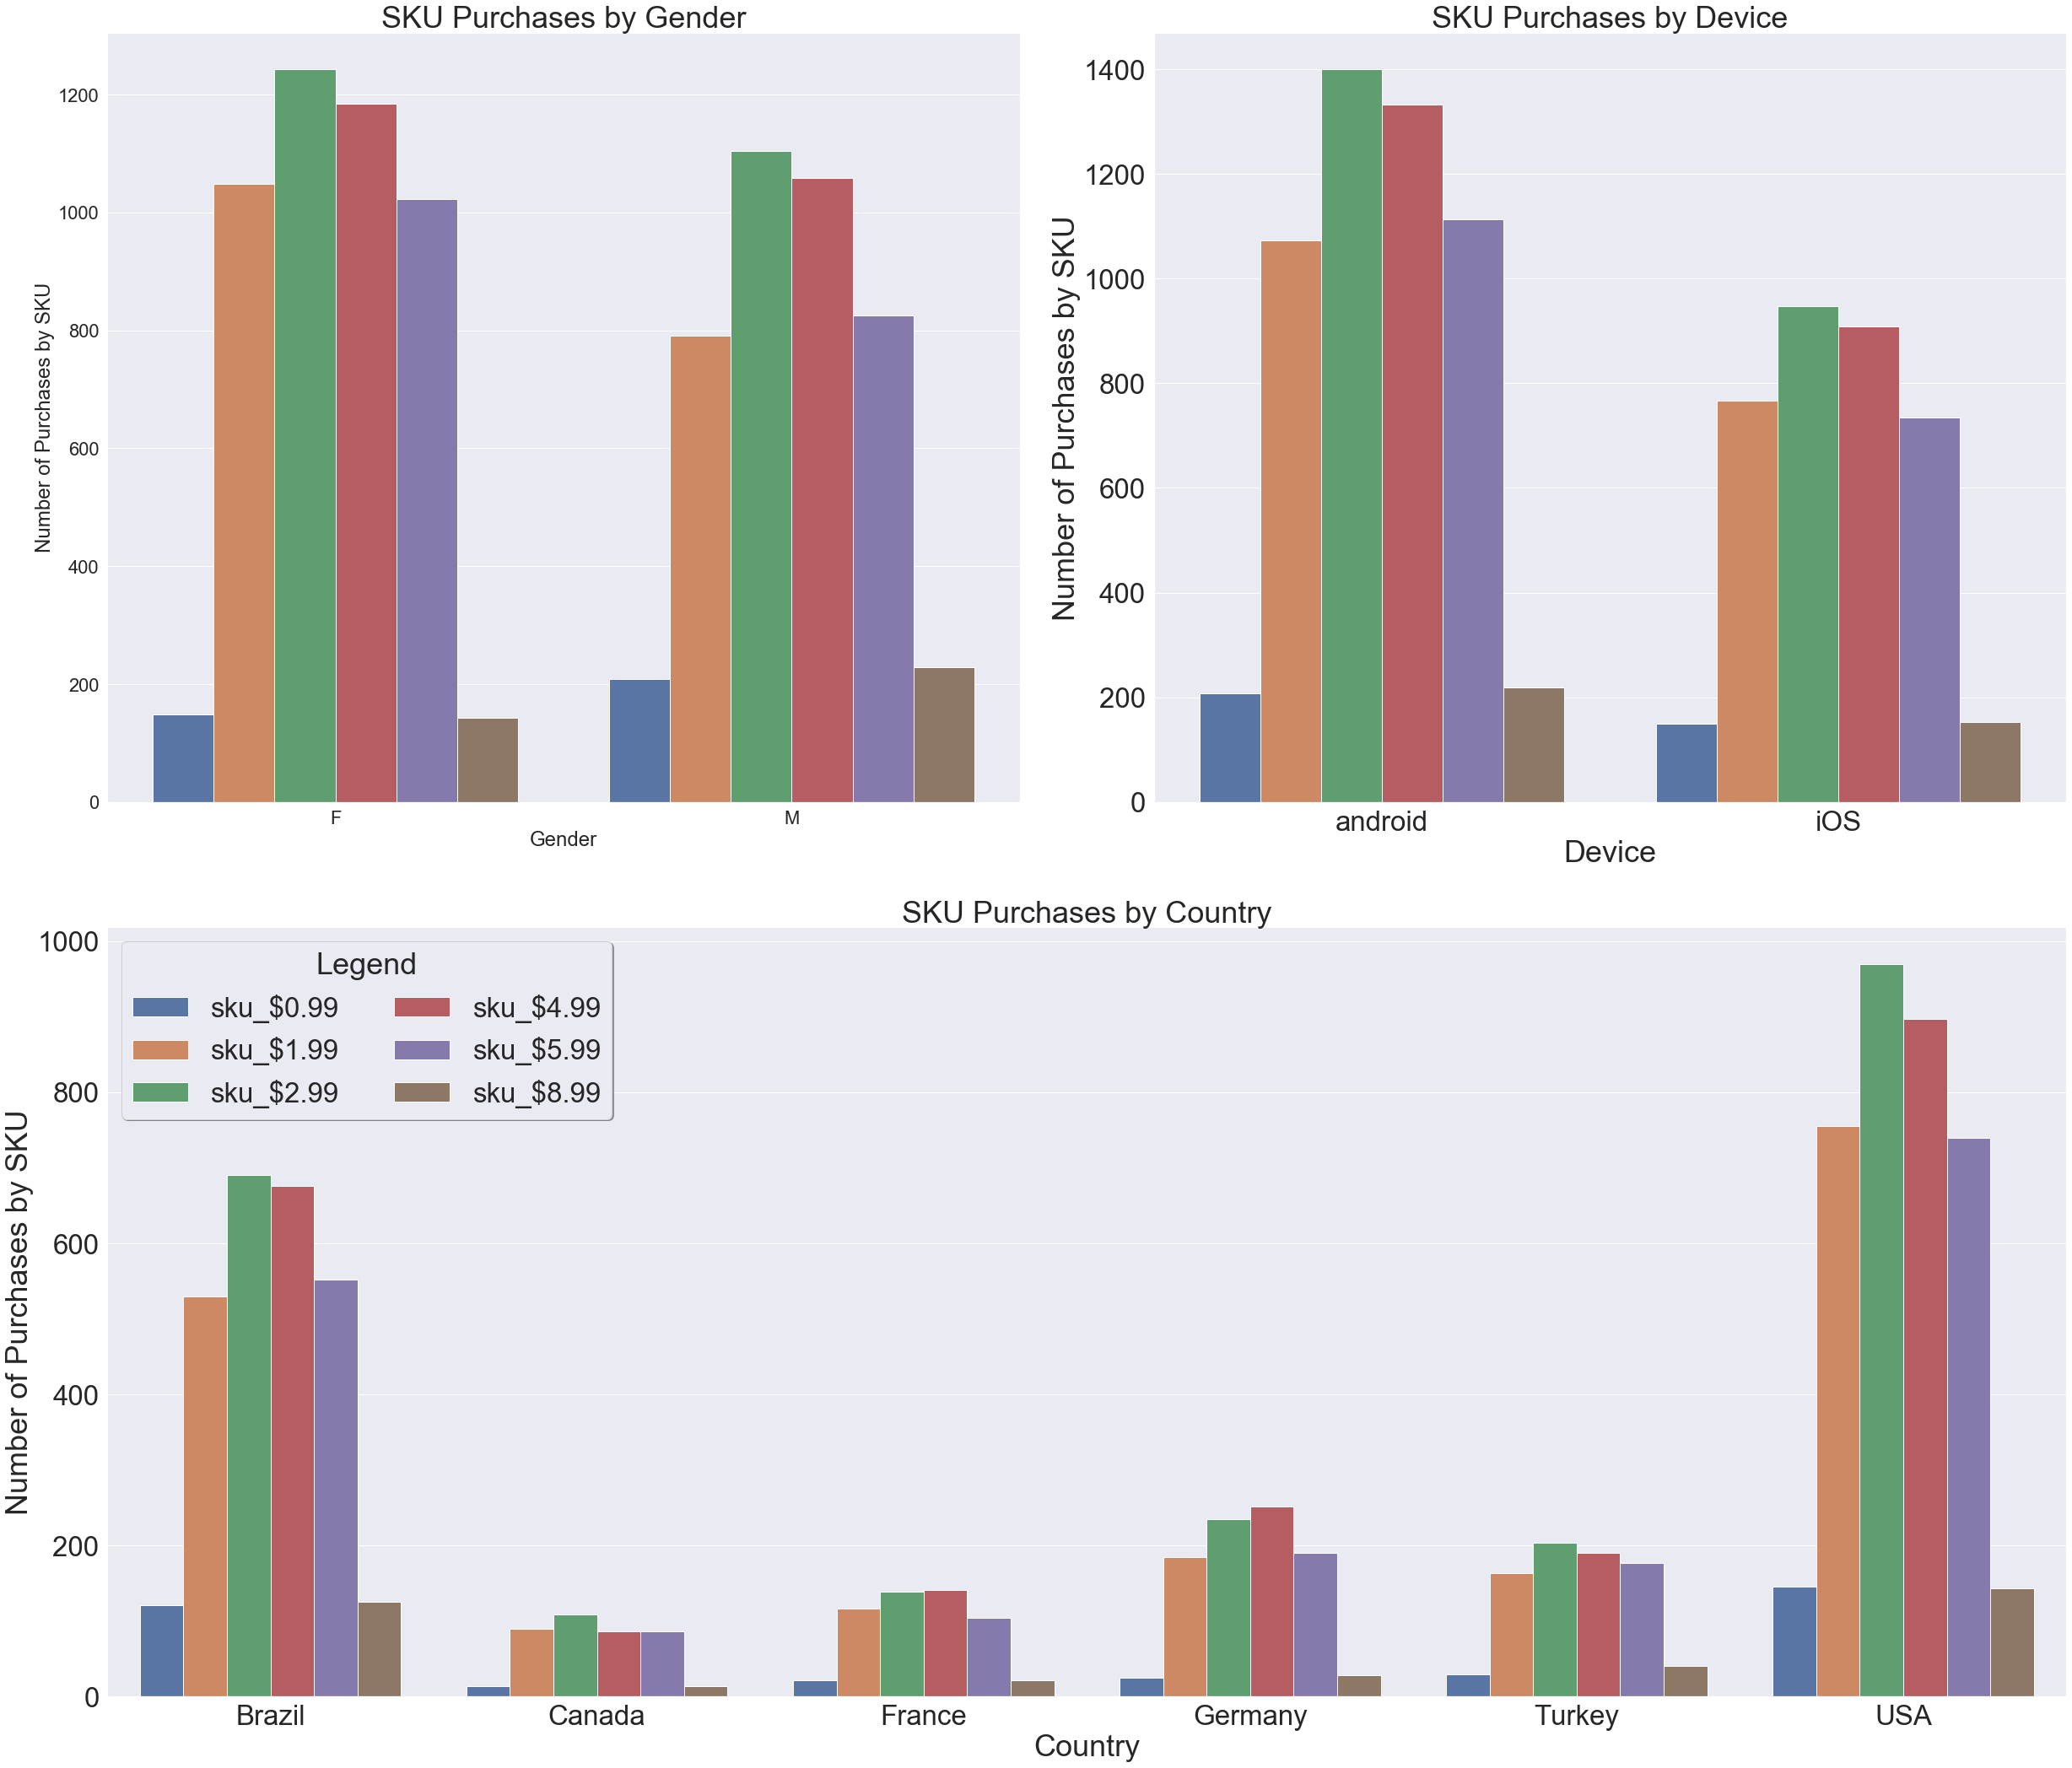

In [262]:
sku_demo = ['gender', 'device', 'country']
fig = plt.figure(figsize=(35,30))
fig.subplots_adjust(hspace=1, wspace=0.2)
for demo, num in zip(sku_demo, range(1,4)):
    if num == 3:
        ax = fig.add_subplot(212)
        sns.set(font_scale=3)
        sns.countplot(x=demo, hue="sku", data=customer_purchases, ax=ax)
        ax.set_ylabel('Number of Purchases by SKU')
        ax.set_xlabel(demo.capitalize())
        ax.set_title(f"SKU Purchases by {demo.capitalize()}")
        ax.legend().set_visible(False)
    else:
        ax = fig.add_subplot(2,2, num)
        sns.set(font_scale=3)
        sns.countplot(x=demo, hue="sku", data=customer_purchases, ax=ax) 
        ax.set_ylabel('Number of Purchases by SKU')
        ax.set_xlabel(demo.capitalize())
        ax.set_title(f"SKU Purchases by {demo.capitalize()}")
        ax.legend().set_visible(False)

plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=2, shadow=True, title="Legend", fancybox=True)
plt.tight_layout()
plt.savefig("static/images/figure7_demo_purchases.png", bbox_inches='tight')
plt.show()

The top 4 products for all countries are: sku_four_599, sku_one_199, sku_three_499, sku_two_299.
Brazil has a higher proportion of their customers that purchase sku_eight_2099, and sku_five_899 than other countries. This may account for the higher median sale of prices.

## Baseline Sales EDA Key performance index (KPI)

### Multivariate Sales Analysis
 - Sales by country and gender (cat)
 - Sales by country and device (cat)
 - Sales by country and age (cont)

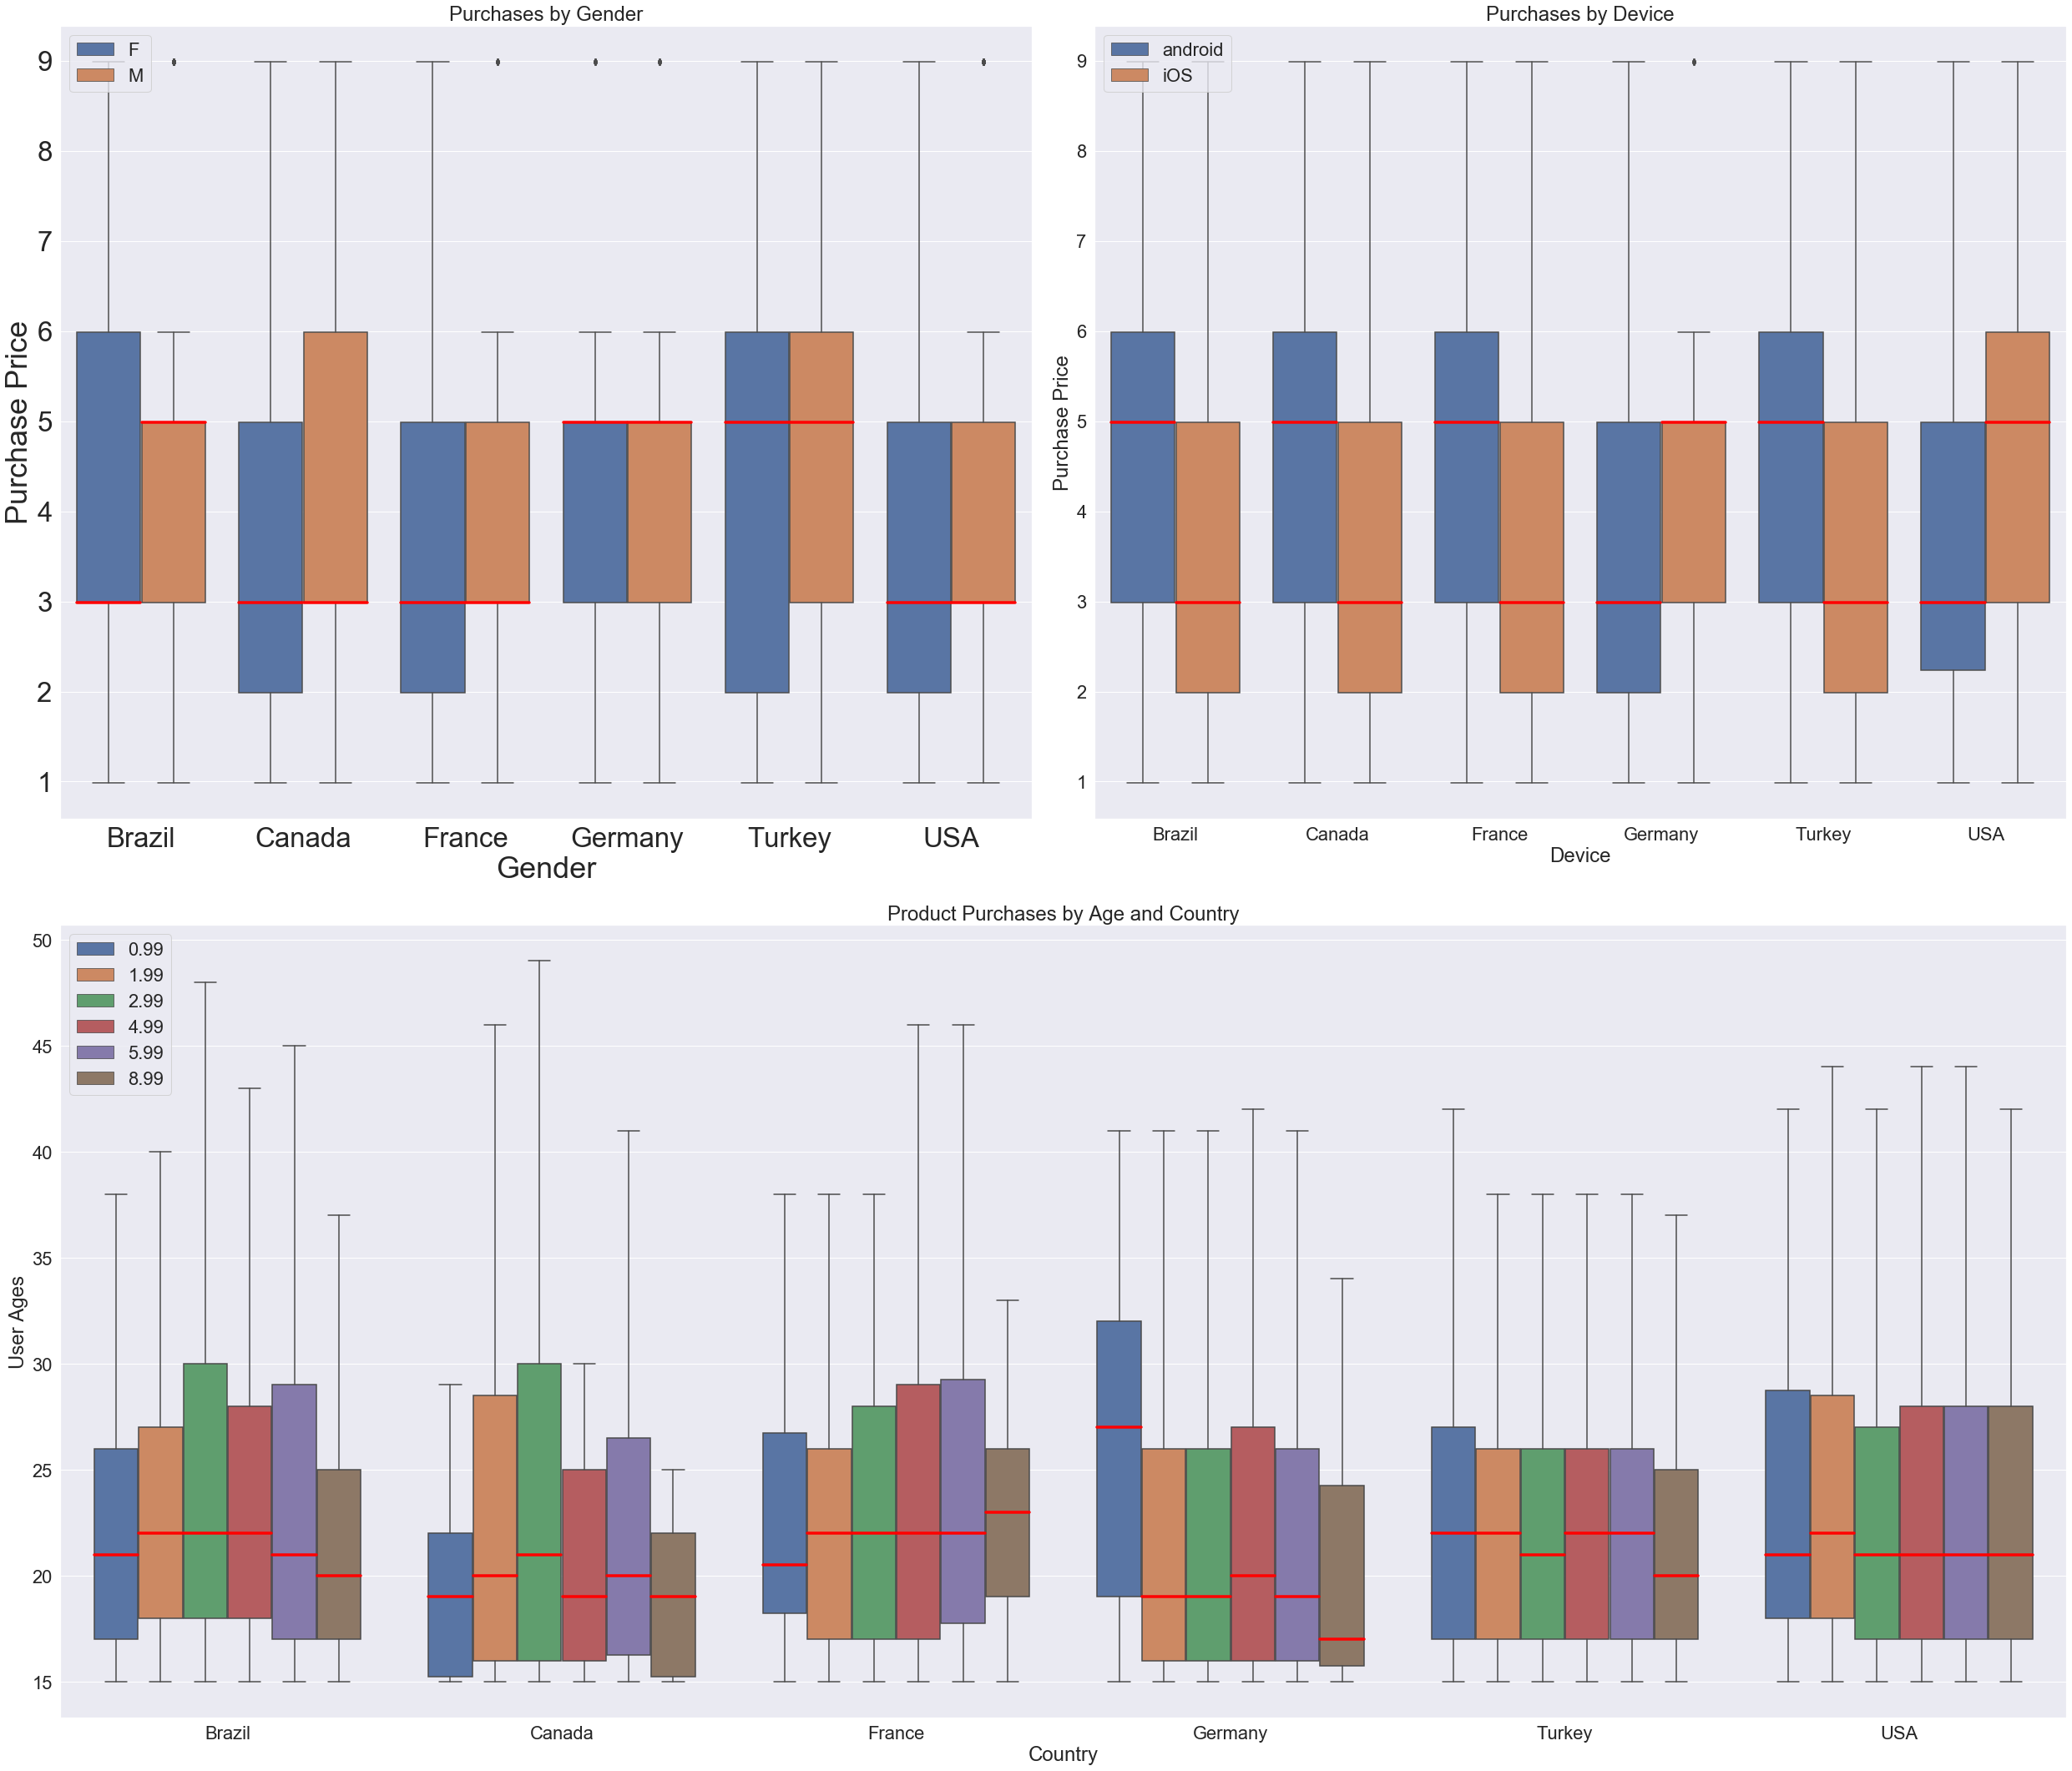

In [261]:
sku_demo = ['gender', 'device', 'age']
fig = plt.figure(figsize=(35,30))
# plt.rcParams.update({'font.size': 28})
fig.subplots_adjust(hspace=1, wspace=0.2)
for demo, num in zip(sku_demo, range(1,4)):
    if num == 3:
        ax = fig.add_subplot(212)
        sns.boxplot(x="country", y="age", hue='price', data=customer_purchases, medianprops={'color':'red', 'linewidth': 3.5}, sym='', ax=ax)
        sns.set(font_scale=2)
        ax.set_ylabel('User Ages')
        ax.set_xlabel('Country')
        ax.set_title(f"Product Purchases by {demo.capitalize()} and Country")
        ax.legend(loc='upper left')
    else:
        ax = fig.add_subplot(2,2, num)
        sns.boxplot(x="country", y="price", hue=demo, data=customer_purchases, medianprops={'color':'red', 'linewidth': 3.5}, ax=ax) 
        sns.set(font_scale=2)
        ax.set_ylabel('Purchase Price')
        ax.set_xlabel(demo.capitalize())
        ax.set_title(f"Purchases by {demo.capitalize()}")
        ax.legend(loc="upper left")

plt.tight_layout()
plt.savefig("static/images/figure6_demo_purchases.png", bbox_inches='tight')
plt.show()

In all countries, but Brazil, males make higher median purchases by price than females.
Men in France spent more than other countries, while men in Canada spent the least.
Bottomline: All there are more female customers by country, males are making bigger purchases than females in all but Brazil.
Higher purchases are made in Android devices in all countries but Germany and the US, where iOS is higher.

## Baseline Sales EDA Key performance index (KPI)

### Multivariate Purchase Analysis
 - Sales by gender, country, and device (x-axis)
 - Sale Counts by country, kpu, and gender (x-axis)
 - Proportion of sales by product (y-axis) and country and gender (x-axis)

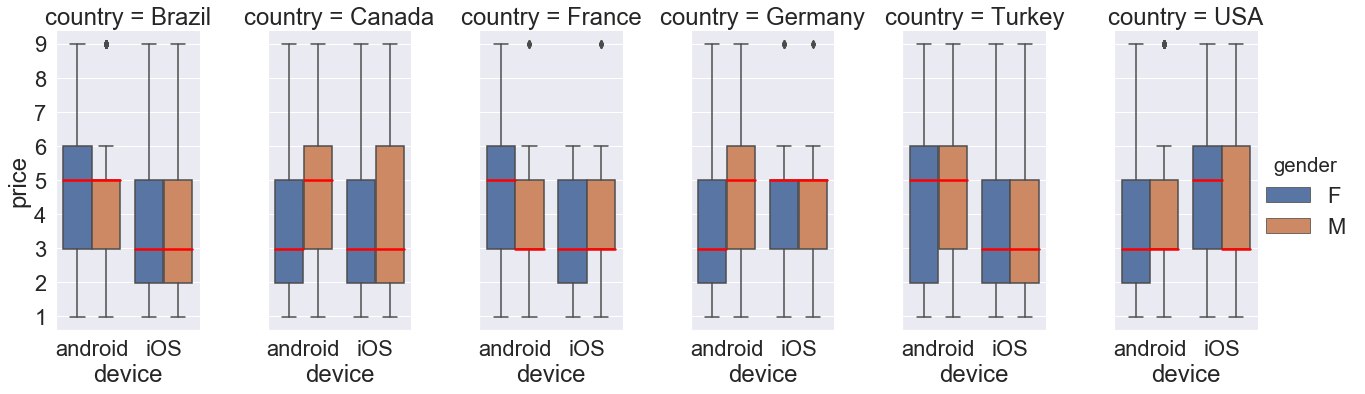

In [238]:
# Sales by gender, country, and device
g = sns.catplot(x="device", y="price",
                hue="gender", col="country",
                data=customer_purchases, kind="box",
                height=6, aspect=.5, medianprops={'color':'red', 'linewidth': 2.5});
sns.set(rc={'figure.figsize':(15,20)})
plt.rcParams.update({'font.size': 14})
# plt.savefig("static/images/plot_catplot_customer_purchases_country_price_gender.png", bbox_inches='tight')
plt.show()

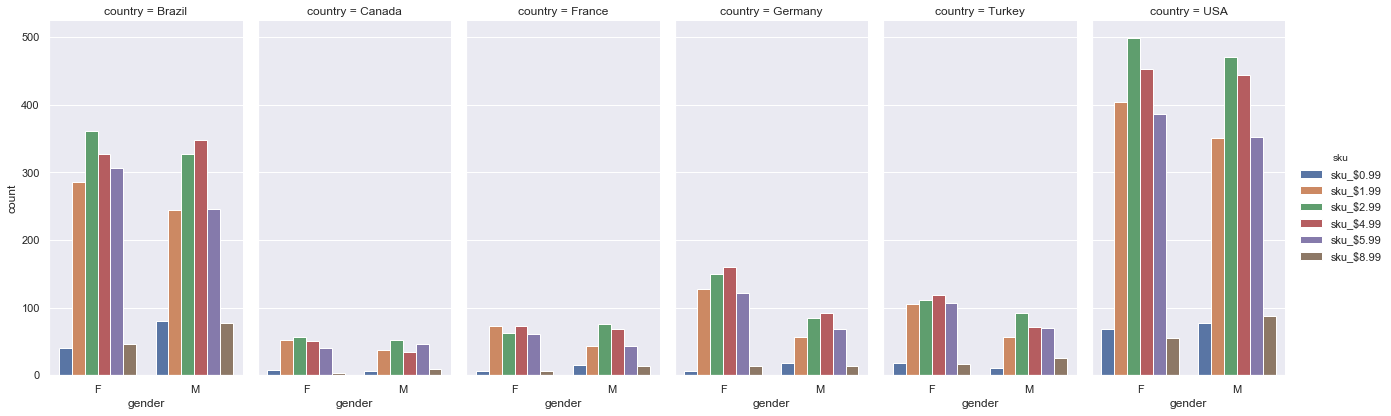

In [239]:
g = sns.catplot(x="gender",
                hue="sku", col="country",
                data=customer_purchases, kind="count",
                height=6, aspect=.5)
sns.set(rc={'figure.figsize':(10,20)})
# plt.savefig("static/images/plot_catplot_gender_sku_country_price.png", bbox_inches='tight')
plt.show()

In [259]:
# Use the pivot_table method to plot the mix of products purchased by country and by gender
sku_counts_by_gender_country = pd.pivot_table(customer_purchases, values='price', index=['country', 'gender'], columns=['sku'], aggfunc='count')
# Counts as a Proportion
sku_proportion_by_gender_country = sku_counts_by_gender_country.div(sku_counts_by_gender_country.sum(axis=1), axis=0)
sku_proportion_by_gender_country

sku             sku_$0.99  sku_$1.99  sku_$2.99  sku_$4.99  sku_$5.99  \
country gender                                                          
Brazil  F        0.029927   0.208759   0.264234   0.239416   0.223358   
        M        0.060423   0.184290   0.247734   0.262840   0.185801   
Canada  F        0.037736   0.245283   0.268868   0.240566   0.188679   
        M        0.032086   0.203209   0.278075   0.187166   0.245989   
France  F        0.024648   0.257042   0.221831   0.257042   0.214789   
        M        0.057692   0.169231   0.292308   0.261538   0.165385   
Germany F        0.012048   0.220310   0.258176   0.275387   0.209983   
        M        0.053892   0.170659   0.254491   0.275449   0.203593   
Turkey  F        0.037657   0.221757   0.234310   0.248954   0.223849   
        M        0.033742   0.174847   0.282209   0.217791   0.214724   
USA     F        0.036442   0.216506   0.267417   0.242765   0.207395   
        M        0.043722   0.196749   0.264013   0.248879   0.197309   

sku             sku_$8.99  
country gender             
Brazil  F        0.034307  
        M        0.058912  
Canada  F        0.018868  
        M        0.053476  
France  F        0.024648  
        M        0.053846  
Germany F        0.024096  
        M        0.041916  
Turkey  F        0.033473  
        M        0.076687  
USA     F        0.029475  
        M        0.049327

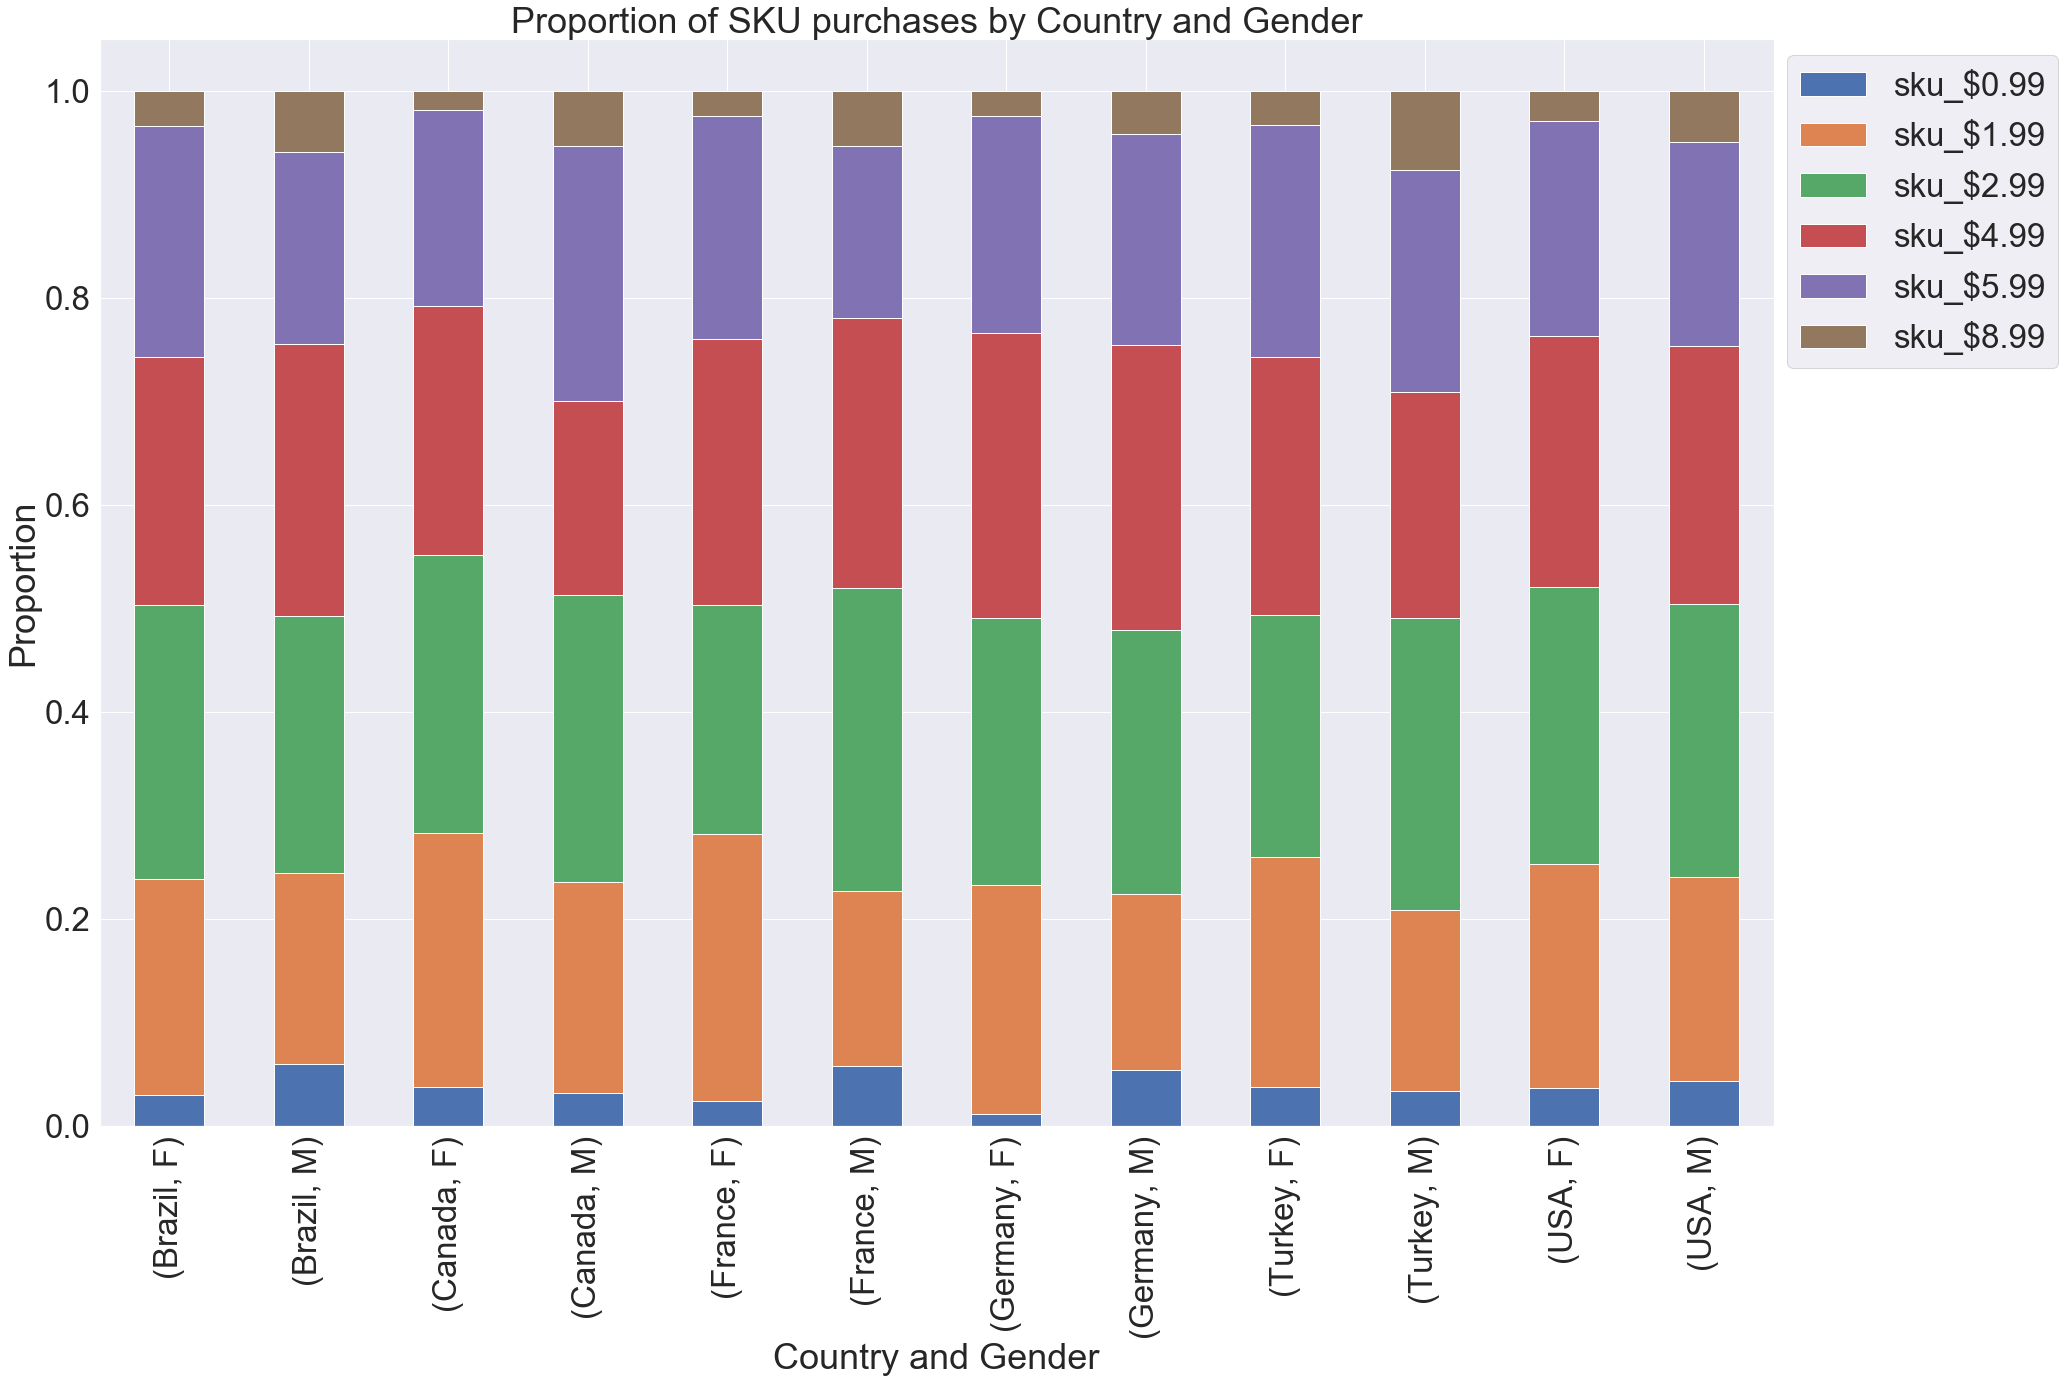

In [263]:
ax = sku_proportion_by_gender_country.plot.bar(stacked=True, figsize=(30,20))
plt.ylabel("Proportion")
plt.xlabel("Country and Gender")
plt.title("Proportion of SKU purchases by Country and Gender")
plt.legend(loc='upper right', bbox_to_anchor=(1.18, 1), ncol=1)
plt.savefig("static/images/figure8_demo_purchases.png", bbox_inches='tight')
plt.show()

# Examine baseline KPI  "purchases" using groupby
 - dataset: customer_purchases
 - sort values by price, then groupby, and then review summary
#### Evaluate the purchasing behaviors by country and speficially:
 - total transactions in this period
 - the sum of these transactions
 - the mean purchase by country
 - the median purchase by country
 - the standard deviation by country
 - the min purchase made (dollars)
 - the max purchase made (dollars)
 - the mean, and median age of purchases
 - the youngest and oldest customer

In [ ]:
# Group data by country
country_device_subset = customer_purchases.groupby(by=['country'], axis=0, as_index=False)

In [ ]:
sku_purchases = customer_purchases.groupby('sku')['price'].agg({'price': 'max', 'count' : 'count'})
sku_purchases

In [ ]:
# Create a dictionary that will be used to aggregate the groupby object
func_dic = {'price': ['count', 'sum', 'mean', 'median', 'std'], 
            'age': ['mean','median', 'std', 'min', 'max']}
# Apply the dictionary, reset the index, assign to a new variable, and sort values by 
# the multi-level index using a tuple
grouped = country_device_subset.agg(func_dic).reset_index(drop=True)
# Drop index name from column
grouped.columns = grouped.columns.droplevel(0)
grouped.columns = ["Country", "Nbr Purchases", "Purchase Sum", "Mean Purchase Price", "Median Purchase Price", "Purchase Price std", 'Mean Age', 'Median Age', 'Age Std', 'Min Age', 'Max Age']
grouped.sort_values('Nbr Purchases', ascending=False).style.hide_index()

### Summary of results
 - USA had the highest number of purchases in terms of counts, and sum, made lots of smaller purchases (how can we get them to buy higher priced products?)
 - Brazil was the 2nd highest country with transaction counts although Brazil had higher mean purchases than US customers (some of these purchases were higher priced products)
 - Turkey had the highest mean purchases (they had fewer transactions, but spent more per transaction)
 - Canada has the lowest customer purchases in counts, sum, mean, median
 
Customer Age Demographics
 - USA had the oldest mean age customers
 - Brazil had the oldest median age
 - Germany had the youngest mean and median customers

# Examine KPI "conversion rate" a week after registering
 - dataset: need to create a dataframe that has subscription data

In [ ]:
current_date = pd.to_datetime('2018-03-17')

In [ ]:
# Create cutoff date
week1_cutoff = current_date - timedelta(days=7)
week2_cutoff = current_date - timedelta(days=14)
print(week1_cutoff, week2_cutoff)

### Function to calculate the conversion rate for either the 1st week or 2nd week

In [ ]:
def cal_conversion(time_frame, purchase_period, cutoff):
    # Restrict users whose 7 day free trial lapsed  
    users = customer_purchases[(customer_purchases[time_frame] <= cutoff)]
    # Restrict users whose 7 day free trial 'lapsed' (ended)
    # before 2018-03-10 and made a purchase before their their free trial ended
    paying_users = customer_purchases[(customer_purchases[time_frame] <= cutoff) 
                                                     & (customer_purchases[purchase_period] == 1)]
    # The total count of users in this period
    total_users = len(users["uid"].unique())
    # The total count of users that paid in this period
    total_paying_users = len(paying_users["uid"].unique())
    
    # The ratio of users that paid in this period
    conversion_rate = total_paying_users/total_users
    
    return round(conversion_rate, 3)

In [ ]:
week1 = cal_conversion('week1_lapse_date', "purchase_dur_week1", week1_cutoff)
week2 = cal_conversion('week2_lapse_date', "purchase_dur_week2", week2_cutoff)
print(week1, week2)

In [ ]:
def cal_conversion_cohort(time_frame, cutoff, demo, instance, purchase_period):
    period = customer_purchases[(customer_purchases[time_frame] <= cutoff)]
    
    # Filter by demographic     
    demographic_df = period.loc[period[demo] == instance]
    
    # Total number of users in period
    total_unique_users = len(demographic_df["uid"].unique())

    # All purchases made by this demographic in this period
    total_purchases = demographic_df.loc[demographic_df[purchase_period] == 1]
    
    # The number of paying users in this period
    total_purchasing_unique_users = len(total_purchases["uid"].unique())
    
    demo_conversion_rate = total_purchasing_unique_users/total_unique_users
    
    return round(demo_conversion_rate, 3)

In [ ]:
# Gender converstion rate
male_week1 = cal_conversion_cohort('week1_lapse_date', week1_cutoff, 'gender', 'M', 'purchase_dur_week1')
female_week1 = cal_conversion_cohort('week1_lapse_date', week1_cutoff, 'gender', 'F', 'purchase_dur_week1')
male_week2 = cal_conversion_cohort('week2_lapse_date', week2_cutoff, 'gender', 'M', 'purchase_dur_week2')
female_week2 = cal_conversion_cohort('week2_lapse_date', week2_cutoff, 'gender', 'F', 'purchase_dur_week2')
print(male_week1, female_week1, male_week2, female_week2)

In [ ]:
android_week1 = cal_conversion_cohort('week1_lapse_date', week1_cutoff, 'device', 'android', 'purchase_dur_week1')
iOS_week1 = cal_conversion_cohort('week1_lapse_date', week1_cutoff, 'device', 'iOS', 'purchase_dur_week1')
android_week2 = cal_conversion_cohort('week2_lapse_date', week2_cutoff, 'device', 'android', 'purchase_dur_week2')
iOS_week2 = cal_conversion_cohort('week2_lapse_date', week2_cutoff, 'device', 'iOS', 'purchase_dur_week2')
print(android_week1, iOS_week1, android_week2, iOS_week2)

In [ ]:
def cal_conversion_multi_cohort(time_frame, cutoff, demo1, instance1, demo2, instance2, purchase_period):
    period = customer_purchases[(customer_purchases[time_frame] <= cutoff)]
    
    # Filter by demographic     
    demographic_df = period.loc[(period[demo1] == instance1) & (period[demo2] == instance2)]
    
    # Total number of users in period
    total_unique_users = len(demographic_df["uid"].unique())

    # All purchases made by this demographic in this period
    total_purchases = demographic_df.loc[demographic_df[purchase_period] == 1]
    
    # The number of paying users in this period
    total_purchasing_unique_users = len(total_purchases["uid"].unique())
    
    demo_conversion_rate = total_purchasing_unique_users/total_unique_users
    
    return round(demo_conversion_rate, 3)

In [ ]:
m_wk1_a = cal_conversion_multi_cohort('week1_lapse_date', week1_cutoff, 'device', 'android', 'gender', 'M', 'purchase_dur_week1')
m_wk2_a = cal_conversion_multi_cohort('week2_lapse_date', week2_cutoff, 'device', 'android', 'gender', 'M', 'purchase_dur_week2')
f_wk1_a = cal_conversion_multi_cohort('week1_lapse_date', week1_cutoff, 'device', 'android', 'gender', 'F', 'purchase_dur_week1')
f_wk2_a = cal_conversion_multi_cohort('week2_lapse_date', week2_cutoff, 'device', 'android', 'gender', 'F', 'purchase_dur_week2')
print(m_wk1_a, m_wk2_a, f_wk1_a, f_wk2_a)

In [ ]:
m_wk1_iOS = cal_conversion_multi_cohort('week1_lapse_date', week1_cutoff, 'device', 'iOS', 'gender', 'M', 'purchase_dur_week1')
m_wk2_iOS = cal_conversion_multi_cohort('week2_lapse_date', week2_cutoff, 'device', 'iOS', 'gender', 'M', 'purchase_dur_week2')
f_wk1_iOS = cal_conversion_multi_cohort('week1_lapse_date', week1_cutoff, 'device', 'iOS', 'gender', 'F', 'purchase_dur_week1')
f_wk2_iOS = cal_conversion_multi_cohort('week2_lapse_date', week2_cutoff, 'device', 'iOS', 'gender', 'F', 'purchase_dur_week2')
print(m_wk1_iOS, m_wk2_iOS, f_wk1_iOS, f_wk2_iOS)

### KPI: the average amount paid per purchase within a user's first 28 days
 - customer_purchases
 - this KPI can provide a sense of the popularity of different in-app purchase price points to users within their first month.

In [ ]:
max_purchase_date = current_date - timedelta(days=28)

In [ ]:
# Filter to only include users who registered before our max date
purchase_data_filt = customer_purchases[customer_purchases['registration_date'] < max_purchase_date]

In [ ]:
# Filter to contain only purchases within the first 28 days of 
# registration
purchase_data_filt = purchase_data_filt[(purchase_data_filt['purchase_date'] <=
                                         purchase_data_filt['registration_date'] + 
                                         timedelta(days=28))]

In [ ]:
# Output the mean price paid per purchase
print(purchase_data_filt.price.mean())

Interesting! Since our average price is 414 cents which is below $4.99 it seems that our purchasers tend towards the lower priced set of options.

### Average purchase price by cohort

In [ ]:
# Set the max registration date to be one month before today
max_reg_date = current_date - timedelta(days=28)

In [ ]:
# Find the month 1 values:
month1 = np.where((customer_purchases.registration_date < max_reg_date) &
                    (customer_purchases.purchase_date < customer_purchases.registration_date + timedelta(days=28)),
                  customer_purchases.price, 
                  np.NaN)

In [ ]:
# Update the value in the DataFrame
customer_purchases['month1'] = month1

In [ ]:
# Group the data by gender and device 
purchase_data_upd = customer_purchases.groupby(by=['gender', 'device'], as_index=False)

In [ ]:
# Aggregate the month1 and price data 
purchase_summary = purchase_data_upd.agg(
                        {'month1': ['mean', 'median', 'std'],
                        'price': ['mean', 'median','std']})

In [ ]:
# Remove tuple in column header
purchase_summary.columns = purchase_summary.columns.droplevel(0)

In [ ]:
purchase_summary

Great! This value seems relatively stable over the past 28 days. Congratulations on completing Chapter 1! In the next chapter, you'll explore and visualize customer behavior in more detail.

### Analysis of sales over time
 - Overview
 - Cohorts

In [ ]:
# Group the data and aggregate first_week_purchases
user_purchases = customer_purchases.groupby(by=['registration_date', 'uid']).agg({'purchase_dur_week1': ['sum']})

In [ ]:
# Reset the indexes
user_purchases.columns = user_purchases.columns.droplevel(level=1)
user_purchases.reset_index(inplace=True)

# Find the average number of purchases per day by first-week users
user_purchases = user_purchases.groupby(by=['registration_date']).agg({'purchase_dur_week1': ['mean']})
user_purchases.columns = user_purchases.columns.droplevel(level=1)
user_purchases.reset_index(inplace=True)
# Add 1st week lapse period
user_purchases["week1_lapse_date"] = user_purchases['registration_date'] + timedelta(days=7)

In [ ]:
# Plot the emw mean of 1st week purchases for the entire dataset
plt.figure(figsize=(8,8))
plt.plot(user_purchases['registration_date'],user_purchases['purchase_dur_week1'].ewm(span=100).mean())
plt.xticks(rotation=90)
plt.ylabel("First Week Exponential Weighted Moving Mean Purchases")
plt.savefig("static/images/plot_first_wk_purchases_ewm.png", bbox_inches='tight')
plt.show()

In [ ]:
### Plot the results
upp = user_purchases.plot(figsize=(8,8), x='registration_date', y='purchase_dur_week1')
upp.plot()
plt.ylabel("Average First Week Purchases")
plt.xlabel("Registration Dates")
plt.savefig("static/images/plot_first_wk_purchases_timeseries.png", bbox_inches='tight')
plt.show()

### Review first week purchase rate by country

In [ ]:
# Create a groupby df for country, registration dates, and purchase summaries
user_purchases_country = customer_purchases.groupby(by=['registration_date','country'], as_index=False)['purchase_dur_week1'].agg('mean')
# Replace all na with 0
user_purchases_country['purchase_dur_week1'].fillna(0, inplace=True)

In [ ]:
# Pivot the data
country_pivot = pd.pivot_table(user_purchases_country, values=['purchase_dur_week1'], columns=['country'], index=['registration_date'])

### Plot first week purchases by country summary

In [ ]:
# Plot the average first week purchases for each country by registration date
country_pivot.plot(figsize=(15,20), subplots=True, layout=(3, 2), sharex=False, sharey=False)
plt.suptitle("Average Purchases within 1st Week of Subscription", fontsize=16, y=1.01)
plt.ylabel("Average First Week Purchases")
plt.xlabel("Registration Dates")
plt.tight_layout()
plt.savefig("static/images/plot_first_wk_purchases_by_country.png", bbox_inches='tight')
plt.show()

Brazil and USA have high recent purchases

### Review first week purchase rate by device

In [ ]:
# Create a groupby df for country, registration dates, and purchase summaries
user_purchases_device = customer_purchases.groupby(by=['registration_date','device'], as_index=False)['purchase_dur_week1'].agg('mean')
# Replace all na with 0
user_purchases_device['purchase_dur_week1'].fillna(0, inplace=True)

In [ ]:
# Pivot the data
device_pivot = pd.pivot_table(user_purchases_device, values=['purchase_dur_week1'], columns=['device'], index=['registration_date'])

In [ ]:
# Remove tuple in column header
device_pivot.columns = device_pivot.columns.droplevel(0)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9), nrows=2, ncols=1, sharex=False)
device_pivot['android'].plot(kind='line', legend=True, ax=ax[0], color='blue')
ax[0].set_ylabel('Average First Week Purchases', fontsize=14)
ax[0].set_title('Average Purchases in First Week by Device', color='black', fontsize=18)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[0].set_xlabel('Dates', fontsize=14)
leg = ax[0].legend()
for text in leg.get_texts():
    plt.setp(text, color = 'black')

device_pivot['iOS'].plot(kind='line', legend=True, ax=ax[1], color='darkorange')
ax[1].set_ylabel('Average First Week Purchases', fontsize=14)
ax[1].tick_params(axis='both', which='both', labelsize=14)
ax[1].set_xlabel('Dates', fontsize=14)
leg = ax[1].legend()
for text in leg.get_texts():
    plt.setp(text, color = 'black')

fig.tight_layout()

plt.savefig("static/images/plot_first_wk_purchases_by_device.png", bbox_inches='tight')
plt.show()

# Revenue
 - Review the revenue data for this app
 - dataset: revenue

### Clean data

In [ ]:
sku_dict = {'sku_eight_2099': 'sku_$0.99',
            'sku_five_899':'sku_$8.99',
            'sku_four_599':'sku_$5.99',
            'sku_one_199' :'sku_$1.99',
            'sku_seven_1499':'sku_$4.99',
            'sku_six_1299':'sku_$2.99', 
            'sku_three_499':'sku_$4.99',
            'sku_two_299':'sku_$2.99'}
# Rename values in the column
revenue['sku'].replace(sku_dict, inplace= True)

In [ ]:
# Convert price to currency format (without the $ sign as this would change it to a string object)
revenue['price'] = revenue['price'].apply(lambda x: '{:.2f}'.format((x/100)))

In [ ]:
# Convert price to float
revenue['price'] = revenue['price'].astype('float')

In [ ]:
# Change date columns from objects to datetime
revenue['date'] = revenue['date'].astype('datetime64[ns]')

In [ ]:
# Group by daily purchases and aggregate (sum)
daily_revenue = revenue.groupby('date')['price'].agg('sum')
# Convert this groupby object into a dataframe
daily_revenue_df = daily_revenue.to_frame()
# Reset the date index into a column
daily_revenue_df = daily_revenue_df.reset_index()

In [ ]:
# Rename price to revenue
daily_revenue_df = daily_revenue_df.rename(columns={'price':'revenue'})

In [ ]:
# Compute 7_day_rev
daily_revenue_df['7_day_rev'] = daily_revenue_df.revenue.rolling(window=7,center=False).mean()

# Compute 28_day_rev
daily_revenue_df['28_day_rev'] = daily_revenue_df.revenue.rolling(window=28,center=False).mean()
    
# Compute 365_day_rev
daily_revenue_df['365_day_rev'] = daily_revenue_df.revenue.rolling(window=365,center=False).mean()

In [ ]:
# Repalce na with 0
daily_revenue_df = daily_revenue_df.fillna(0)

In [ ]:
# Plot date, and revenue, along with the 3 rolling functions (in order)   
# daily_revenue_df.plot(x='date', y=['revenue', '7_day_rev', '28_day_rev', '365_day_rev', ])

daily_revenue_df.plot(x='date', y=['28_day_rev'], figsize=(8,8))
plt.rcParams.update({'font.size': 28})
plt.xlabel('Dates')
plt.ylabel('Rolling Average')
plt.title('Rolling 28 day Average for Revenue', color='black')
plt.savefig("static/images/plot_rolling_revenue.png", bbox_inches='tight')
plt.show()

Revenue is growing for the business!

### Revenue for a specific product

### SKU product earnings

### Determine which products (SKU) are the top and bottom earners

In [ ]:
revenue.groupby('sku')['price'].agg(['count','sum','mean'])

In [ ]:
# Use groupby to aggregate and calculate the sum by sku
sku_revenue = revenue.groupby('sku')['price'].agg(['count','sum','mean'])
sku_revenue = sku_revenue.rename(columns={'count':'Volume', 'sum':'Total Revenue', 'mean':'Average Revenue'})

In [ ]:
sku_revenue.sort_values(by=['Total Revenue'], ascending=False)

The highest volume product is sku_two_299
The highest earning product in revenue is sku_four_599
The highest selling product by average is sku_five_899

### Transform revenue data for plotting data

In [ ]:
sku_rev_pivot = pd.pivot_table(revenue, values=['price'], columns=['sku'], index=['date'])
sku_rev_pivot = sku_rev_pivot.fillna(0)

### Visualize the ewm for each product sku

In [ ]:
# Get a list of the columns from the pandas pivot table
sku_array = np.asarray(sku_rev_pivot.columns.tolist())

In [ ]:
# Test function
fig = plt.figure(figsize=(35,30))
fig.subplots_adjust(hspace=1, wspace=0.2)
for sku, num in zip(sku_array, range(1,6)):
    to_df = sku_rev_pivot['price'][sku[1]].to_frame().reset_index()
    to_df.columns=['date','revenue']
    to_df['medium_scale'] = to_df.revenue.ewm(span=100).mean()
    ax = fig.add_subplot(2,3, num)
    ax.plot(to_df['date'], to_df['medium_scale'], label=f'revenue for + {sku[1].capitalize()}')
    ax.legend()

    ax.set_title(sku[1].capitalize())
    
plt.tight_layout()
plt.savefig("static/images/plot_all_sku_ewm_revenue.png", bbox_inches='tight')
plt.show()

All products seem to increase in revenue with some sku driving growth

### Revenue by gender and device

### First Subset: <font color="red">user_revenue</font> revenue and customers merged using .merge()

In [ ]:
# Merge on the 'uid'
user_revenue = revenue.merge(customers, on=['uid'], how='inner')

In [ ]:
# Clean up data
user_revenue['sku'] = user_revenue['sku'].astype('category')

In [ ]:
# Rename columns
user_revenue = user_revenue.rename(columns={'date_x' : 'revenue_date', 'date_y' : "registration_date", "price":"revenue"})

In [ ]:
# Rearrange columns
user_revenue = user_revenue[['registration_date', 'device',
       'gender', 'country', 'age', 'revenue_date', 'uid', 'sku', 'revenue', ]]

## Visualize the monthly revenue for one of the updated products and evaluate the results using emw()

### Prepare data for visualization

In [ ]:
# Make a list of product skus
sku_array = np.asarray(user_revenue["sku"].unique().tolist())

In [ ]:
# Test function
fig = plt.figure(figsize=(35,30))
fig.subplots_adjust(hspace=1, wspace=0.2)
for sku, num in zip(sku_array, range(1,9)):
    # Subset data by sku
    sku_df = user_revenue.loc[user_revenue['sku'] == sku]
    grouped_sku_df = sku_df.groupby(['registration_date', 'device', 'gender'])['revenue'].sum().fillna(0).to_frame()
    # Reset index so that we no longer have a multilevel df
    grouped_sku_df.reset_index(inplace=True) 
    # Groupby month and sum revenue
    month_sku_rev = grouped_sku_df.groupby([pd.Grouper(key='registration_date',freq='M'), 'gender', "device"]).agg({'revenue':'sum'})
    # Reset index so that we no longer have a multilevel df
    month_sku_rev.reset_index(inplace=True)
    # Pivot user_revenue
    pivoted_data = pd.pivot_table(month_sku_rev, values ='revenue', columns=['device', 'gender'], index='registration_date')
    pivoted_data = pivoted_data[1:(len(pivoted_data) -1 )]

    # Plot data
    ax = fig.add_subplot(2,4, num)
    ax.plot(pivoted_data.index,pivoted_data[('android', 'F')].ewm(span=100).mean(), label='android, F')
    ax.plot(pivoted_data.index,pivoted_data[('android', 'M')].ewm(span=100).mean(), label='android, M')
    ax.plot(pivoted_data.index,pivoted_data[('iOS', 'F')].ewm(span=100).mean(), label='iOS, F')
    ax.plot(pivoted_data.index,pivoted_data[('iOS', 'M')].ewm(span=100).mean(), label='iOS, M')
    ax.legend()
    ax.set_title(sku)
    
plt.tight_layout()
plt.savefig("static/images/plot_all_sku_device_gender_revenue.png", bbox_inches='tight')
plt.show()

Higher proportion of revenue is obtained from android users
Revenue from women come from sales of the more affordable sku products
Revenue seems to drop after july 2017

# A/B Testing
 - Test change to consumable purchase paywall
 - Goal: Increase revenue by increasing the purchase rate
 - Response variable: KPI or directly related to KPI
 - Factors (the type of variable we are changing) and variants particular changes that will be made)
 - experimental units: smallest unit you are measuring the change over
 - calculating experimental units
 - Paywall view to purchase conversion rate
 - more informative than overall revenue
 - directly related to test
 - experimental unit: paywall views

### Experimental units: Revenue per user day
 - Dataset <font color="red">user_revenue</font>

In [ ]:
user_rev_df = user_revenue.copy()

In [ ]:
# Extract the 'day'; value from the timestamp
user_rev_df.revenue_date = user_rev_df.revenue_date.dt.floor('d')

In [ ]:
# Replace the NaN price values with 0 
user_rev_df.revenue = np.where(np.isnan(user_rev_df.revenue), 0, user_rev_df.revenue)

In [ ]:
# Aggregate the data by 'uid' & 'revenue_date'
purchase_data_agg = user_rev_df.groupby(by=['uid', 'revenue_date'], as_index=False)

In [ ]:
# Sum aggregated data
revenue_user_day = purchase_data_agg.sum()

In [ ]:
# Calculate the final average
revenue_user_day = revenue_user_day.revenue.mean()

In [ ]:
print(f'The revenue per user-day, with user-day as the experimental unit is: ${round(revenue_user_day, 2)}')

### Test Sensitivity
 - the minimal level of change we want to detect in our test
 - evaluate various sensitivity

In [ ]:
# Calculate the total revenue per user over the entire dataset
total_rev = user_revenue.groupby(by=['uid'], as_index=False).revenue.sum()
total_rev.revenue = np.where(np.isnan(total_rev.revenue), 0, total_rev.revenue)

In [ ]:
average_revenue = total_rev.revenue.mean()
print(f'The average revenue is: ${round(average_revenue, 2)}')

In [ ]:
# Test 
def eval_sensitivities(val):
    val1 = val * 1.01 #(1% change in revenue)
    val2 = val * 1.1 #(10% change in revenue)
    val3 = val * 1.2 #(20% change in revenue)
    sensitivities=[val1, val2, val3]
    return(sensitivities)

In [ ]:
eval_sensitivities(average_revenue)

#### Variability in revenue

In [ ]:
revenue_variation = total_rev.revenue.std()
print(f'The variability of revenue is: ${round(revenue_variation, 2)}')

#### Compare revenue variability to revenue mean

In [ ]:
revenue_variation/average_revenue

Variation revenue is 70% of the mean

#### Variability of purchases per user

In [ ]:
# Calculate the total revenue per user over the entire dataset
total_pur = user_revenue.groupby(by=['uid'], as_index=False).revenue.count()
total_pur.revenue = np.where(np.isnan(total_pur.revenue), 0, total_pur.revenue)

In [ ]:
average_pur = total_pur.revenue.mean()
print(f'The average purchase is: {round(average_pur, 2)}')

In [ ]:
pur_variability = total_pur.revenue.std()
print(f'The purchase variability is: {round(pur_variability, 2)}')

In [ ]:
pur_variability/average_pur

Variation in purchases is 69% of the mean